# Camera Calibration

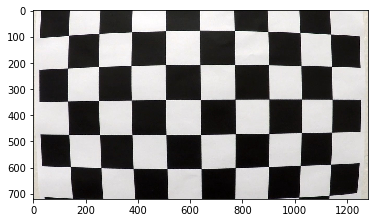

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in a calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
h, w = img.shape[:2]
plt.imshow(img)

In [2]:
import glob
%matplotlib inline

# Read in and make a list of images
images = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# prepare object points, like (0,0,0)....
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# if corners are found, add object points, image points
fnames_valid = []
for fname in images:
    img = mpimg.imread(fname)
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        fnames_valid.append(fname)
        # draw and display the corners
        # print("got!")
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         plt.figure()
#         plt.imshow(img)
    else:
        print("lost!")

lost!
lost!
lost!


## Distrotion-corrested image demonstration

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

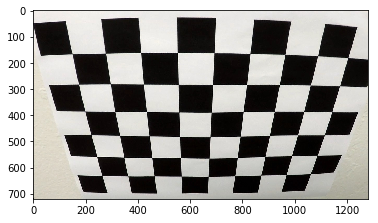

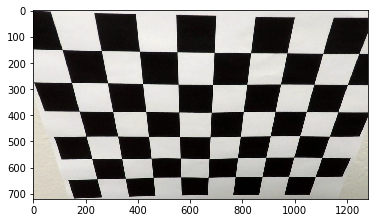

In [7]:
import pickle

img = mpimg.imread('./camera_cal/calibration2.jpg')
# undist
undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(undist)

data = {
    'mtx': mtx,
    'dist': dist
}

with open('camera.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

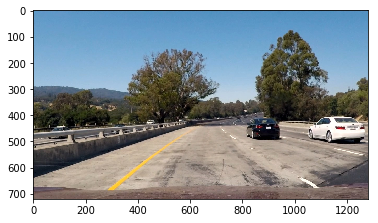

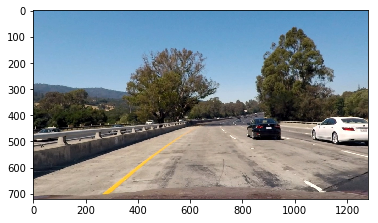

In [112]:
test = mpimg.imread('./test_images/test1.jpg')
# undist
undist = cv2.undistort(test, mtx, dist, None, mtx)
plt.figure()
plt.imshow(test)
plt.figure()
plt.imshow(undist)

## Test images

In [92]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scale_sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= mag_thresh[0]) & (scale_sobel <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direct = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direct)
    binary_output[(direct >= thresh[0]) & (direct <= thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelorient = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobelorient = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobelorient)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hls_grad(img):
    sxbinary = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100)
    sybinary = abs_sobel_thresh(img, orient='y', thresh_min=50, thresh_max=100)
#     dirbinary = dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3))
#     magbinary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
    s_binary = hls_select(img, thresh=(140,255))
    # color binary
    color_binary = np.dstack(( np.zeros_like(sxbinary), s_binary, sxbinary)) * 255
    # combined image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) & (sybinary == 1)] = 1
    return color_binary, combined_binary

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,)
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def transform():
    src = np.float32(
        [[247, 700],
         [590, 450],
         [700, 450],
         [1080, 700]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def find_lane(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#         (0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#         (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

### read and undistort test images

In [48]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera.pickle", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in and make a list of images
test_images = glob.glob('./test_images/*.jpg')

#undistort
undist_imgs = []
for image in test_images:
    img = mpimg.imread(image)
    undist_imgs.append(cv2.undistort(img, mtx, dist, None, mtx))

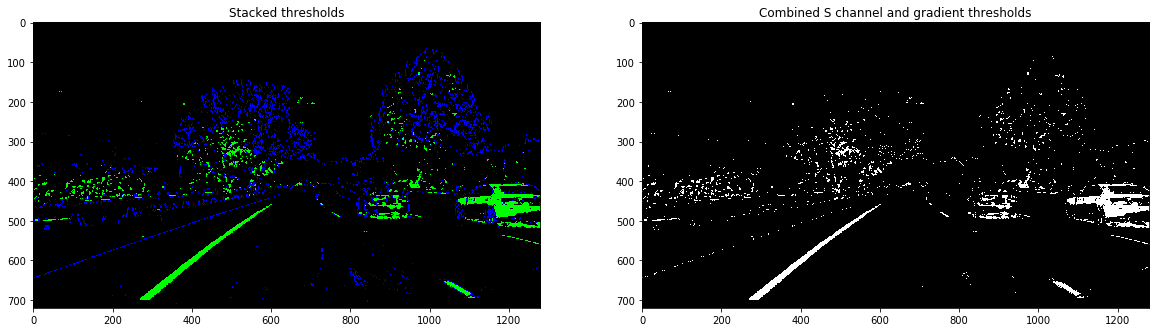

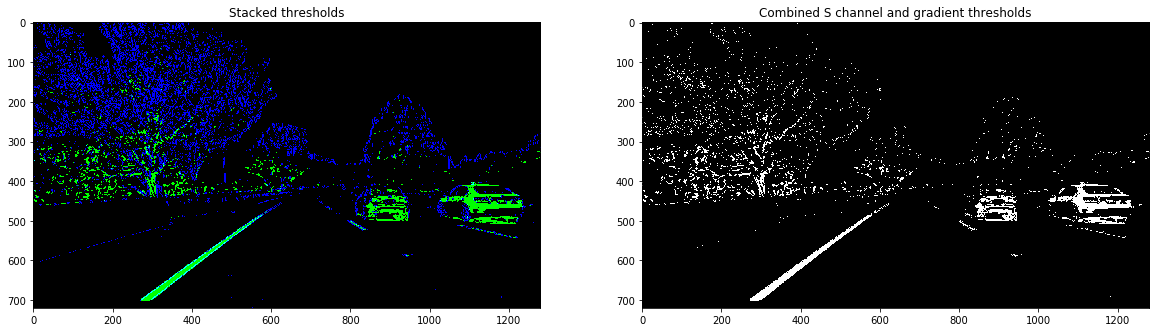

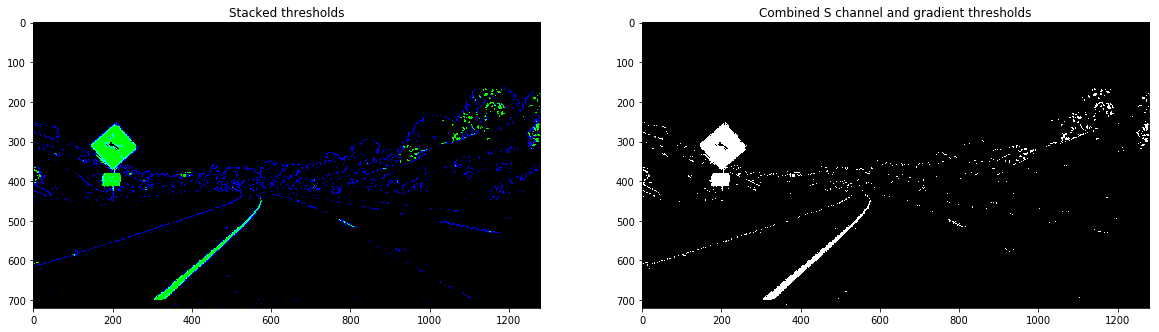

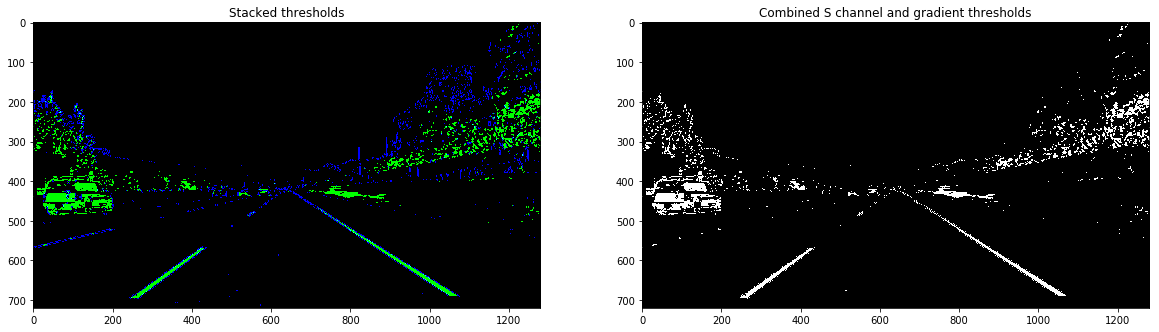

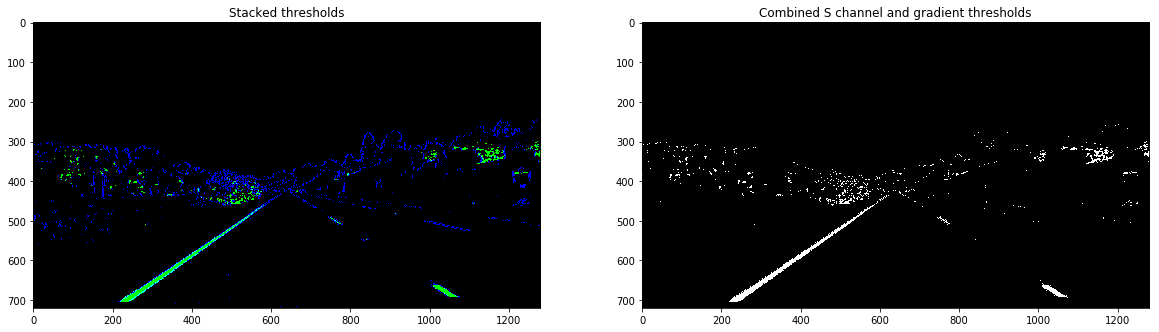

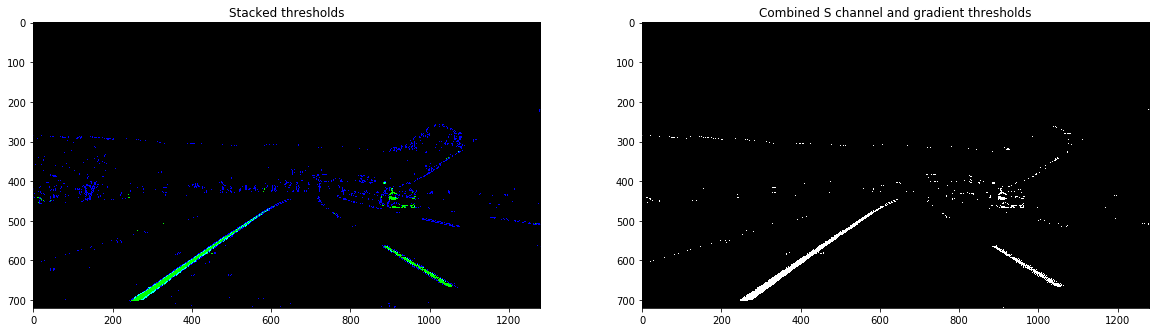

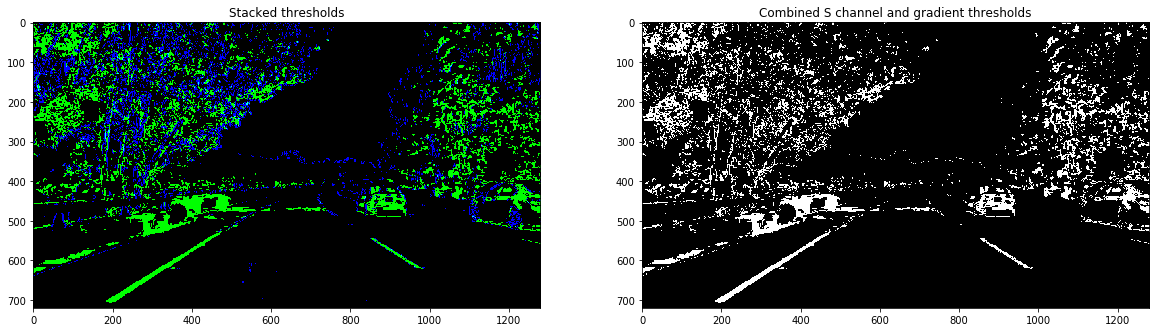

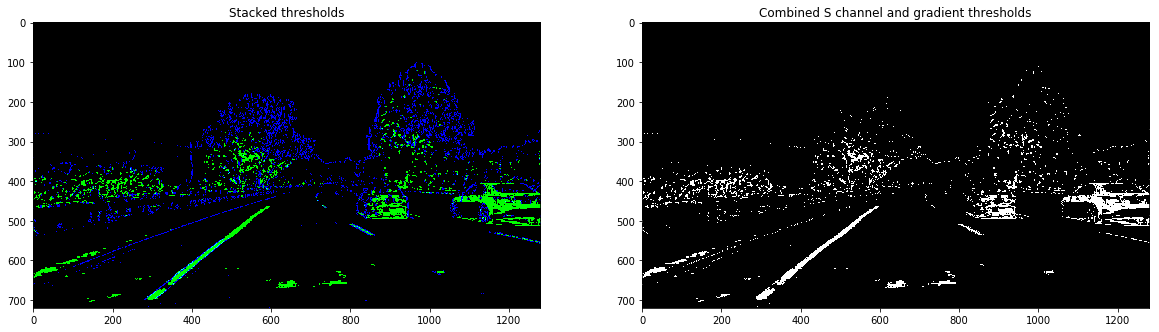

In [49]:
%matplotlib inline
for undist_img in undist_imgs:
#     sxbinary = abs_sobel_thresh(undist_img, orient='x', thresh_min=30, thresh_max=100)
#     sybinary = abs_sobel_thresh(undist_img, orient='y', thresh_min=50, thresh_max=100)
# #     dirbinary = dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3))
# #     magbinary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
#     s_binary = hls_select(undist_img, thresh=(140,255))
#     # color binary
#     color_binary = np.dstack(( np.zeros_like(sxbinary), s_binary, sxbinary)) * 255
#     # combined image
#     combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(s_binary == 1) | (sxbinary == 1) | (sybinary == 1)] = 1
    color_binary, combined_binary = hls_grad(undist_img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')


### perspective transform

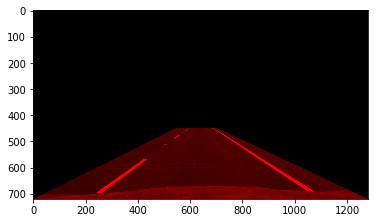

In [76]:
%matplotlib inline

# test straight lines and find points
raw = mpimg.imread('./test_images/straight_lines2.jpg')
imshape = raw.shape
undist_raw = cv2.undistort(raw, mtx, dist, None, mtx)
color_binary, combined_binary = hls_grad(undist_raw)
vertices = np.array([[(0,imshape[0]),(550, 448), (700, 448), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(undist_raw, vertices)

plt.imshow(masked_image)
# test curved lines

In [77]:
src = np.float32(
    [[247, 700],
     [590, 450],
     [700, 450],
     [1080, 700]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

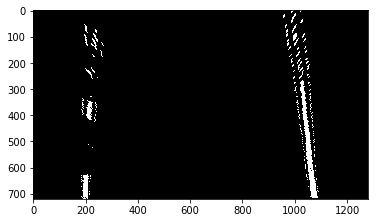

In [78]:
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

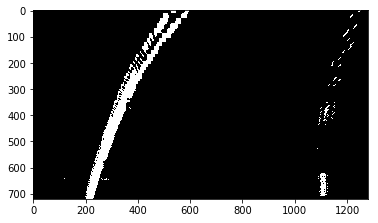

In [80]:
# test curved lines and find points
rawcurve = mpimg.imread('./test_images/test3.jpg')
imshape = rawcurve.shape
undist_raw = cv2.undistort(rawcurve, mtx, dist, None, mtx)
color_binary, combined_binary = hls_grad(undist_raw)
vertices = np.array([[(0,imshape[0]),(550, 448), (700, 448), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(undist_raw, vertices)
binary_warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap="gray")

(720, 0)

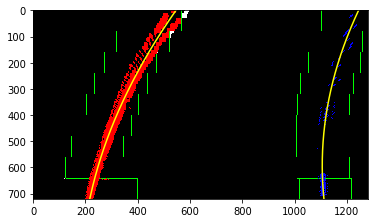

In [82]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

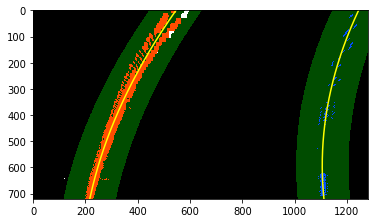

In [84]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


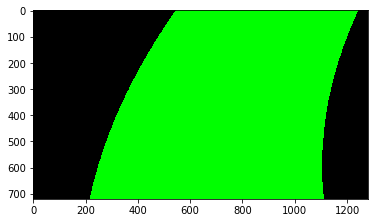

In [89]:
blank_mask = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_mask.astype(np.uint8), cv2.COLOR_GRAY2RGB)
trace = colour_canvas

for index, lrx in enumerate(zip(left_fitx, right_fitx)):
    blank_mask[index][int(lrx[0]):int(lrx[1])] = 1

trace[blank_mask == 1] = [0,255,0]
plt.imshow(trace)

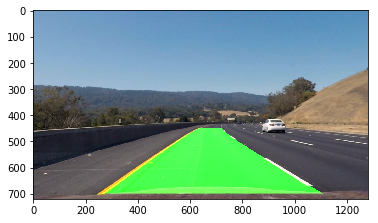

In [90]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, undist_raw)
plt.imshow(combined_img)

In [116]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
center_y = 719
center_left = left_fit[0]*center_y**2 + left_fit[1]*center_y + left_fit[2]
center_right = right_fit[0]*center_y**2 + right_fit[1]*center_y + right_fit[2]
center = (1.5 * center_right - center_left)/2
print("the pos of vehicle is: ",center)

1575.63943181 1286.63473398
the pos of vehicle is:  725.290765808


## Image pipeline

In [108]:
def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = mpimg.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    M, Minv = transform()

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Combine color and gradience
    _ , combined_binary = hls_grad(image)
    binary_warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    
    left_fit, right_fit = find_lane(binary_warped)
    blank_mask = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_mask.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    trace = colour_canvas
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for index, lrx in enumerate(zip(left_fitx, right_fitx)):
        blank_mask[index][int(lrx[0]):int(lrx[1])] = 1

    trace[blank_mask == 1] = [0,255,0]
    # Warp lane boundaries back onto original image
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

    # Convert to colour
    combined_img = cv2.add(lane_lines, image)
    
    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    center_y = 719
    center_left = left_fit[0]*center_y**2 + left_fit[1]*center_y + left_fit[2]
    center_right = right_fit[0]*center_y**2 + right_fit[1]*center_y + right_fit[2]
    center = (1.5 * center_right - center_left)/2
    print("the pos of vehicle is: ",center)
#     plt.imshow(combined_img)

    return combined_img

1780.99914367 1251.68040098
2593.10846095 1663.55065511
963.093056744 1347.74573821
12000.5322713 11807.5952079
149427.248598 55834.6629382
1575.63943181 1286.63473398
787.905019671 804.549281977
1908.73131181 1215.33190596


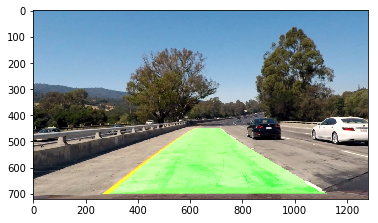

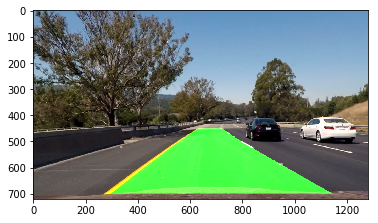

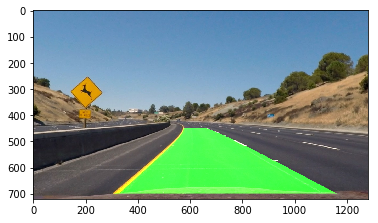

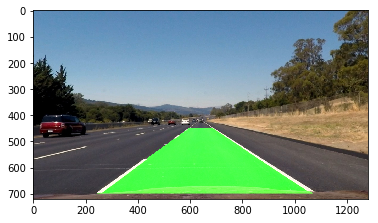

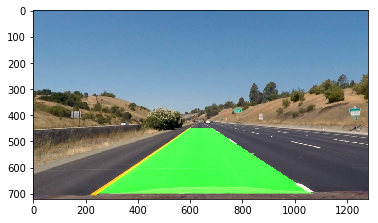

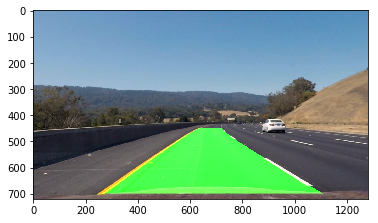

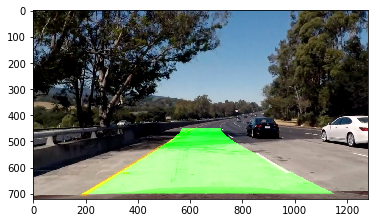

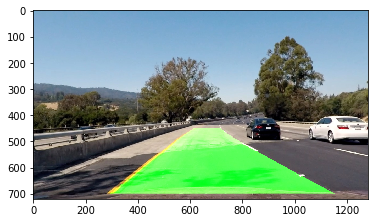

In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

with open("camera.pickle", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

# Read in and make a list of images
test_images = glob.glob('./test_images/*.jpg')

for image in test_images:
    plt.figure()
    combined_image = image_pipeline(image, filepath=True)
    
    


## Video pipeline

In [107]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [110]:
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

987.165681794 2305.17356686
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 1/1261 [00:00<02:36,  8.06it/s]

987.165681794 2305.17356686


  0%|          | 2/1261 [00:00<02:38,  7.96it/s]

991.644220385 1147.12681492


  0%|          | 3/1261 [00:00<02:40,  7.86it/s]

977.838890901 1236.11470294


  0%|          | 4/1261 [00:00<02:38,  7.92it/s]

966.898073343 1460.03248291


  0%|          | 5/1261 [00:00<02:37,  7.95it/s]

981.836216442 1709.92669158


  0%|          | 6/1261 [00:00<02:38,  7.90it/s]

1014.11340419 1081.39124221


  1%|          | 7/1261 [00:00<02:39,  7.87it/s]

1053.99131344 1621.96627543


  1%|          | 8/1261 [00:01<02:39,  7.84it/s]

1042.50943293 1110.50208106


  1%|          | 9/1261 [00:01<02:42,  7.71it/s]

1104.68471574 2064.17602505


  1%|          | 10/1261 [00:01<02:46,  7.51it/s]

1113.10583992 2253.11978802


  1%|          | 11/1261 [00:01<02:56,  7.08it/s]

1145.47384875 2421.85487359


  1%|          | 12/1261 [00:01<03:04,  6.76it/s]

1227.55853772 5604.21727939


  1%|          | 13/1261 [00:01<03:05,  6.74it/s]

1219.24736062 3189.84454807


  1%|          | 14/1261 [00:01<02:57,  7.02it/s]

1234.29620003 2589.25161832


  1%|          | 15/1261 [00:02<02:59,  6.93it/s]

1191.22078616 9288.59390525


  1%|▏         | 16/1261 [00:02<03:01,  6.87it/s]

1123.22455743 1536.4196246


  1%|▏         | 17/1261 [00:02<03:05,  6.71it/s]

1144.67772509 1909.12989834


  1%|▏         | 18/1261 [00:02<03:00,  6.89it/s]

1108.1306409 1156.08482736


  2%|▏         | 19/1261 [00:02<02:55,  7.09it/s]

1230.12471383 1297.23068606


  2%|▏         | 20/1261 [00:02<02:48,  7.36it/s]

1248.81725091 1363.90431827


  2%|▏         | 21/1261 [00:02<02:44,  7.52it/s]

1354.68804619 1487.28519735


  2%|▏         | 22/1261 [00:03<02:44,  7.51it/s]

1392.84235471 1109.2967993


  2%|▏         | 23/1261 [00:03<02:44,  7.54it/s]

1445.69395596 1670.40325653


  2%|▏         | 24/1261 [00:03<02:44,  7.51it/s]

1318.55141687 2234.16598153


  2%|▏         | 25/1261 [00:03<02:44,  7.50it/s]

1249.76272156 1497.71018156


  2%|▏         | 26/1261 [00:03<02:44,  7.49it/s]

1229.2715034 3043.00761498


  2%|▏         | 27/1261 [00:03<02:44,  7.50it/s]

1172.15706091 2011.91304659


  2%|▏         | 28/1261 [00:03<02:50,  7.25it/s]

1174.02112351 1481.45531087


  2%|▏         | 29/1261 [00:03<02:55,  7.01it/s]

1093.77884044 2008.37398397


  2%|▏         | 30/1261 [00:04<03:03,  6.72it/s]

998.732305309 1314.28940557


  2%|▏         | 31/1261 [00:04<03:10,  6.47it/s]

911.063006222 1251.18978121


  3%|▎         | 32/1261 [00:04<02:57,  6.94it/s]

856.578119392 1062.02302259


  3%|▎         | 33/1261 [00:04<02:51,  7.17it/s]

875.599139541 1464.69684514


  3%|▎         | 34/1261 [00:04<02:48,  7.28it/s]

835.034571964 1442.4901535


  3%|▎         | 35/1261 [00:04<02:49,  7.23it/s]

814.603628018 1501.74555234


  3%|▎         | 36/1261 [00:04<02:47,  7.30it/s]

799.276544928 914.364719341


  3%|▎         | 37/1261 [00:05<02:42,  7.51it/s]

798.614760993 989.515196448


  3%|▎         | 38/1261 [00:05<02:38,  7.74it/s]

776.313210704 1155.08953929


  3%|▎         | 39/1261 [00:05<02:38,  7.72it/s]

745.13480376 1842.6603674


  3%|▎         | 40/1261 [00:05<02:42,  7.52it/s]

745.745634697 1011.56205609


  3%|▎         | 41/1261 [00:05<02:41,  7.57it/s]

763.756602726 1150.94795303


  3%|▎         | 42/1261 [00:05<02:40,  7.58it/s]

782.637534332 1251.38890752


  3%|▎         | 43/1261 [00:05<02:40,  7.60it/s]

797.798218436 855.043393833


  3%|▎         | 44/1261 [00:06<02:42,  7.48it/s]

824.548421616 937.279191879


  4%|▎         | 45/1261 [00:06<02:41,  7.53it/s]

858.254615309 1664.82111631


  4%|▎         | 46/1261 [00:06<02:45,  7.34it/s]

892.636271935 992.440397875


  4%|▎         | 47/1261 [00:06<02:53,  6.99it/s]

927.801527951 1681.20579802


  4%|▍         | 48/1261 [00:06<02:48,  7.20it/s]

954.787614456 1354.45626407


  4%|▍         | 49/1261 [00:06<02:40,  7.55it/s]

1049.8014167 1518.84142018


  4%|▍         | 50/1261 [00:06<02:36,  7.72it/s]

1079.12985481 871.797725827


  4%|▍         | 51/1261 [00:06<02:37,  7.68it/s]

1155.06100938 1315.41663089


  4%|▍         | 52/1261 [00:07<02:43,  7.39it/s]

1167.43249768 1925.49724245


  4%|▍         | 53/1261 [00:07<02:49,  7.12it/s]

1176.79680883 1829.83550869


  4%|▍         | 54/1261 [00:07<02:49,  7.11it/s]

1201.06393557 1523.89567774


  4%|▍         | 55/1261 [00:07<02:50,  7.08it/s]

1240.54262594 1283.4192725


  4%|▍         | 56/1261 [00:07<02:48,  7.15it/s]

1325.66539558 1357.65010296


  5%|▍         | 57/1261 [00:07<02:52,  6.97it/s]

1303.4713531 1041.95658084


  5%|▍         | 58/1261 [00:07<02:51,  7.01it/s]

1369.38949357 1842.04545762


  5%|▍         | 59/1261 [00:08<02:49,  7.08it/s]

1339.15158818 1770.70585458


  5%|▍         | 60/1261 [00:08<02:43,  7.34it/s]

1256.75623034 2048.26154329


  5%|▍         | 61/1261 [00:08<02:49,  7.09it/s]

1248.33131338 3155.62949735


  5%|▍         | 62/1261 [00:08<02:46,  7.19it/s]

1213.49221176 2443.42061527


  5%|▍         | 63/1261 [00:08<02:40,  7.48it/s]

1231.11719473 2598.54850812


  5%|▌         | 64/1261 [00:08<02:39,  7.52it/s]

1166.8617437 7283.54716158


  5%|▌         | 65/1261 [00:08<02:37,  7.59it/s]

1162.83394189 1853.85544946


  5%|▌         | 66/1261 [00:09<02:33,  7.77it/s]

1127.19502262 1225.41941708


  5%|▌         | 67/1261 [00:09<02:37,  7.59it/s]

1125.15572082 1335.60812875


  5%|▌         | 68/1261 [00:09<02:42,  7.34it/s]

1166.21355825 1263.78946848


  5%|▌         | 69/1261 [00:09<02:43,  7.29it/s]

1144.50352983 1385.86957463


  6%|▌         | 70/1261 [00:09<02:42,  7.33it/s]

1237.91172735 1381.30814873


  6%|▌         | 71/1261 [00:09<02:44,  7.26it/s]

1224.6642713 720.251119196


  6%|▌         | 72/1261 [00:09<02:41,  7.34it/s]

1328.82638639 951.364369306


  6%|▌         | 73/1261 [00:09<02:39,  7.45it/s]

1357.11198479 1197.65207635


  6%|▌         | 74/1261 [00:10<02:37,  7.52it/s]

1425.86680674 1413.10234659


  6%|▌         | 75/1261 [00:10<02:43,  7.24it/s]

1573.0533568 1303.02233366


  6%|▌         | 76/1261 [00:10<02:46,  7.10it/s]

1586.81604988 1179.72826459


  6%|▌         | 77/1261 [00:10<02:45,  7.15it/s]

1766.65796066 2356.41826242


  6%|▌         | 78/1261 [00:10<02:46,  7.10it/s]

1882.39013092 995.462664868


  6%|▋         | 79/1261 [00:10<02:47,  7.04it/s]

1907.50450749 1146.91597439


  6%|▋         | 80/1261 [00:10<02:47,  7.07it/s]

1791.59768887 1244.08278513


  6%|▋         | 81/1261 [00:11<02:41,  7.29it/s]

1704.2238393 1264.45405878


  7%|▋         | 82/1261 [00:11<02:40,  7.37it/s]

1674.80860264 1149.95726658


  7%|▋         | 83/1261 [00:11<02:44,  7.18it/s]

1564.96987631 1119.84518114


  7%|▋         | 84/1261 [00:11<02:44,  7.17it/s]

1637.72617225 1638.26121864


  7%|▋         | 85/1261 [00:11<02:46,  7.06it/s]

1608.84028693 1461.385509


  7%|▋         | 86/1261 [00:11<02:44,  7.13it/s]

1406.81841883 1430.91581842


  7%|▋         | 87/1261 [00:11<02:46,  7.07it/s]

1263.04746144 1581.92626953


  7%|▋         | 88/1261 [00:12<02:46,  7.05it/s]

1138.77145562 1656.89907453


  7%|▋         | 89/1261 [00:12<02:45,  7.08it/s]

1094.85710075 2583.67664497


  7%|▋         | 90/1261 [00:12<02:42,  7.20it/s]

1020.71390604 1781.75113926


  7%|▋         | 91/1261 [00:12<02:42,  7.18it/s]

1033.09011378 1231.71799543


  7%|▋         | 92/1261 [00:12<02:40,  7.26it/s]

1051.24335423 1494.56431223


  7%|▋         | 93/1261 [00:12<02:37,  7.43it/s]

1013.54262581 1271.90621122


  7%|▋         | 94/1261 [00:12<02:39,  7.33it/s]

995.033220719 1315.15835488


  8%|▊         | 95/1261 [00:13<02:39,  7.31it/s]

1013.33168517 1400.20012945


  8%|▊         | 96/1261 [00:13<02:39,  7.30it/s]

1015.34166924 1387.56174122


  8%|▊         | 97/1261 [00:13<02:43,  7.13it/s]

1005.15229914 2129.64916469


  8%|▊         | 98/1261 [00:13<02:43,  7.09it/s]

1034.03319811 1323.4449005


  8%|▊         | 99/1261 [00:13<02:40,  7.24it/s]

1007.62261754 1145.85382373


  8%|▊         | 100/1261 [00:13<02:39,  7.26it/s]

1033.12071954 1081.40085953


  8%|▊         | 101/1261 [00:13<02:39,  7.26it/s]

1030.04479811 1155.87280213


  8%|▊         | 102/1261 [00:13<02:38,  7.33it/s]

1004.43537288 1078.53925905


  8%|▊         | 103/1261 [00:14<02:41,  7.18it/s]

999.819032281 977.799594243


  8%|▊         | 104/1261 [00:14<02:42,  7.14it/s]

997.113567066 1006.47246317


  8%|▊         | 105/1261 [00:14<02:40,  7.19it/s]

1040.05796142 1091.1395372


  8%|▊         | 106/1261 [00:14<02:39,  7.24it/s]

1045.33712765 1199.09506433


  8%|▊         | 107/1261 [00:14<02:38,  7.27it/s]

1066.27815535 1304.90384421


  9%|▊         | 108/1261 [00:14<02:35,  7.43it/s]

1001.99059902 1088.93037384


  9%|▊         | 109/1261 [00:14<02:37,  7.30it/s]

991.322804068 1218.34799799


  9%|▊         | 110/1261 [00:15<02:35,  7.42it/s]

977.358232175 1757.07660372


  9%|▉         | 111/1261 [00:15<02:30,  7.62it/s]

969.118093178 2215.10430904


  9%|▉         | 112/1261 [00:15<02:28,  7.75it/s]

1017.90342391 1895.79386813


  9%|▉         | 113/1261 [00:15<02:33,  7.48it/s]

971.716254368 1019.1400341


  9%|▉         | 114/1261 [00:15<02:25,  7.86it/s]

952.498501921 911.660969072


  9%|▉         | 115/1261 [00:15<02:24,  7.92it/s]

899.131297255 1579.68312755


  9%|▉         | 116/1261 [00:15<02:22,  8.05it/s]

880.043984315 680.727476949


  9%|▉         | 117/1261 [00:15<02:25,  7.89it/s]

887.096692804 1020.84678263


  9%|▉         | 118/1261 [00:16<02:19,  8.18it/s]

882.085941384 1002.09218286


  9%|▉         | 119/1261 [00:16<02:18,  8.24it/s]

886.26390401 858.078301669


 10%|▉         | 120/1261 [00:16<02:20,  8.12it/s]

860.226862027 1020.44897489


 10%|▉         | 121/1261 [00:16<02:26,  7.81it/s]

876.068033393 918.848099041


 10%|▉         | 122/1261 [00:16<02:23,  7.93it/s]

881.7196885 1165.85272531


 10%|▉         | 123/1261 [00:16<02:22,  7.99it/s]

862.79783948 1048.19199595


 10%|▉         | 124/1261 [00:16<02:19,  8.16it/s]

843.77739315 1034.82785318


 10%|▉         | 125/1261 [00:16<02:20,  8.08it/s]

848.76270745 830.744064022


 10%|▉         | 126/1261 [00:17<02:26,  7.73it/s]

894.226265682 803.998611152


 10%|█         | 127/1261 [00:17<02:27,  7.68it/s]

893.074657692 874.738700307


 10%|█         | 128/1261 [00:17<02:28,  7.65it/s]

908.697673499 811.776710457


 10%|█         | 129/1261 [00:17<02:29,  7.57it/s]

913.056107903 1285.62097462


 10%|█         | 130/1261 [00:17<02:28,  7.64it/s]

989.15718518 1187.42956991


 10%|█         | 131/1261 [00:17<02:25,  7.77it/s]

990.669363742 1610.66372264


 10%|█         | 132/1261 [00:17<02:26,  7.68it/s]

1008.01654169 1202.65731147


 11%|█         | 133/1261 [00:18<02:32,  7.39it/s]

1015.40170833 1077.68291249


 11%|█         | 134/1261 [00:18<02:29,  7.55it/s]

1040.03615605 1640.12902726


 11%|█         | 135/1261 [00:18<02:26,  7.68it/s]

1113.19173048 1156.57367301


 11%|█         | 136/1261 [00:18<02:25,  7.72it/s]

1106.34677859 3609.75792075


 11%|█         | 137/1261 [00:18<02:24,  7.77it/s]

1159.02480975 1373.08685072


 11%|█         | 138/1261 [00:18<02:23,  7.82it/s]

1216.39470989 1423.83656318


 11%|█         | 139/1261 [00:18<02:22,  7.87it/s]

1268.15053624 2154.60462156


 11%|█         | 140/1261 [00:18<02:23,  7.79it/s]

1289.27421354 2322.89641153


 11%|█         | 141/1261 [00:19<02:26,  7.63it/s]

1294.00681127 1821.70617056


 11%|█▏        | 142/1261 [00:19<02:24,  7.77it/s]

1295.07410137 1566.13953805


 11%|█▏        | 143/1261 [00:19<02:22,  7.82it/s]

1217.92695953 1411.67024107


 11%|█▏        | 144/1261 [00:19<02:19,  7.98it/s]

1216.48937483 1281.38012319


 11%|█▏        | 145/1261 [00:19<02:21,  7.89it/s]

1223.49057878 1044.65335636


 12%|█▏        | 146/1261 [00:19<02:21,  7.89it/s]

1161.61436377 1399.90465566


 12%|█▏        | 147/1261 [00:19<02:22,  7.80it/s]

1179.33109814 2064.82743297


 12%|█▏        | 148/1261 [00:19<02:19,  8.00it/s]

1074.82025423 1635.81694833


 12%|█▏        | 149/1261 [00:20<02:20,  7.94it/s]

1080.23528564 1562.48470684


 12%|█▏        | 150/1261 [00:20<02:19,  7.98it/s]

1165.34184838 2311.10415999


 12%|█▏        | 151/1261 [00:20<02:18,  8.00it/s]

1207.62375777 1720.98530136


 12%|█▏        | 152/1261 [00:20<02:15,  8.18it/s]

1245.12099069 1814.31755298


 12%|█▏        | 153/1261 [00:20<02:15,  8.17it/s]

1160.73440914 1001.62531183


 12%|█▏        | 154/1261 [00:20<02:14,  8.22it/s]

1177.14677559 1183.37688914


 12%|█▏        | 155/1261 [00:20<02:11,  8.40it/s]

1201.56072901 1866.26618907


 12%|█▏        | 156/1261 [00:20<02:10,  8.44it/s]

1167.95553701 1469.64038704


 12%|█▏        | 157/1261 [00:21<02:14,  8.23it/s]

1160.44400004 1242.68044679


 13%|█▎        | 158/1261 [00:21<02:18,  7.97it/s]

1098.22581589 1085.57574787


 13%|█▎        | 159/1261 [00:21<02:16,  8.08it/s]

1081.87975303 3262.05737184


 13%|█▎        | 160/1261 [00:21<02:15,  8.12it/s]

1050.52824978 1132.61516971


 13%|█▎        | 161/1261 [00:21<02:19,  7.90it/s]

1078.53778075 2091.923495


 13%|█▎        | 162/1261 [00:21<02:19,  7.87it/s]

1090.30150889 1204.21645767


 13%|█▎        | 163/1261 [00:21<02:18,  7.95it/s]

1098.11715722 1936.073382


 13%|█▎        | 164/1261 [00:21<02:15,  8.12it/s]

1049.44012453 1031.35086336


 13%|█▎        | 165/1261 [00:22<02:15,  8.07it/s]

1020.67225244 849.329879829


 13%|█▎        | 166/1261 [00:22<02:15,  8.09it/s]

1012.2658062 1260.56427913


 13%|█▎        | 167/1261 [00:22<02:14,  8.16it/s]

1003.97880632 2315.76896685


 13%|█▎        | 168/1261 [00:22<02:12,  8.25it/s]

1088.95224473 1272.20075303


 13%|█▎        | 169/1261 [00:22<02:15,  8.03it/s]

1074.51406281 1355.93524169


 13%|█▎        | 170/1261 [00:22<02:13,  8.18it/s]

1176.78190905 1531.94887536


 14%|█▎        | 171/1261 [00:22<02:19,  7.84it/s]

1136.06978204 933.957781453


 14%|█▎        | 172/1261 [00:22<02:17,  7.91it/s]

1163.51110405 789.758246667


 14%|█▎        | 173/1261 [00:23<02:17,  7.90it/s]

1143.65183081 1310.38165324


 14%|█▍        | 174/1261 [00:23<02:15,  8.03it/s]

1022.77141715 659.426008332


 14%|█▍        | 175/1261 [00:23<02:14,  8.08it/s]

1045.28705731 831.657929885


 14%|█▍        | 176/1261 [00:23<02:13,  8.11it/s]

1040.42534189 980.678999136


 14%|█▍        | 177/1261 [00:23<02:16,  7.92it/s]

1046.86122104 894.966206021


 14%|█▍        | 178/1261 [00:23<02:15,  8.01it/s]

992.108644067 677.205060133


 14%|█▍        | 179/1261 [00:23<02:17,  7.86it/s]

962.675657113 713.098643718


 14%|█▍        | 180/1261 [00:23<02:14,  8.05it/s]

1003.39846031 732.154450632


 14%|█▍        | 181/1261 [00:24<02:14,  8.06it/s]

926.992688322 859.749060582


 14%|█▍        | 182/1261 [00:24<02:14,  8.05it/s]

925.952790707 807.107711462


 15%|█▍        | 183/1261 [00:24<02:13,  8.05it/s]

856.985465371 676.468292219


 15%|█▍        | 184/1261 [00:24<02:13,  8.09it/s]

835.621723567 962.321551932


 15%|█▍        | 185/1261 [00:24<02:17,  7.82it/s]

800.684472917 1014.15008211


 15%|█▍        | 186/1261 [00:24<02:16,  7.89it/s]

741.758923352 1471.99463012


 15%|█▍        | 187/1261 [00:24<02:14,  7.99it/s]

740.600472338 1148.39902655


 15%|█▍        | 188/1261 [00:24<02:12,  8.09it/s]

725.185578472 1132.08093996


 15%|█▍        | 189/1261 [00:25<02:14,  7.99it/s]

722.054039769 955.355396253


 15%|█▌        | 190/1261 [00:25<02:13,  8.05it/s]

719.26413919 1403.22504237


 15%|█▌        | 191/1261 [00:25<02:12,  8.08it/s]

714.745632492 1348.6959836


 15%|█▌        | 192/1261 [00:25<02:10,  8.20it/s]

731.828577366 1138.0569299


 15%|█▌        | 193/1261 [00:25<02:11,  8.15it/s]

730.659778492 1703.3648081


 15%|█▌        | 194/1261 [00:25<02:09,  8.24it/s]

750.579215625 1192.09372979


 15%|█▌        | 195/1261 [00:25<02:07,  8.35it/s]

758.64758617 804.976004922


 16%|█▌        | 196/1261 [00:25<02:05,  8.47it/s]

848.690753862 851.27728181


 16%|█▌        | 197/1261 [00:25<02:06,  8.43it/s]

931.324657989 1774.30359305


 16%|█▌        | 198/1261 [00:26<02:06,  8.41it/s]

1114.14813445 1182.29086585


 16%|█▌        | 199/1261 [00:26<02:08,  8.23it/s]

1228.25037864 996.343935195


 16%|█▌        | 200/1261 [00:26<02:09,  8.22it/s]

1191.8081705 1198.37589058


 16%|█▌        | 201/1261 [00:26<02:12,  7.98it/s]

1210.40502186 3031.77093282


 16%|█▌        | 202/1261 [00:26<02:12,  8.00it/s]

1105.44626589 1582.04508964


 16%|█▌        | 203/1261 [00:26<02:12,  7.98it/s]

1058.86887957 1000.74801623


 16%|█▌        | 204/1261 [00:26<02:13,  7.91it/s]

1063.66662158 1101.35074594


 16%|█▋        | 205/1261 [00:26<02:14,  7.83it/s]

996.935743336 1318.55906585


 16%|█▋        | 206/1261 [00:27<02:13,  7.87it/s]

979.536916402 1196.57093117


 16%|█▋        | 207/1261 [00:27<02:09,  8.16it/s]

895.604112586 1065.4008671


 16%|█▋        | 208/1261 [00:27<02:05,  8.38it/s]

861.007559704 1885.73938721


 17%|█▋        | 209/1261 [00:27<02:08,  8.20it/s]

892.227863423 2425.33358127


 17%|█▋        | 210/1261 [00:27<02:08,  8.20it/s]

919.649384605 2365.27032659


 17%|█▋        | 211/1261 [00:27<02:13,  7.89it/s]

973.792935659 1372.30537727


 17%|█▋        | 212/1261 [00:27<02:09,  8.09it/s]

947.006829639 2067.94896881


 17%|█▋        | 213/1261 [00:27<02:06,  8.27it/s]

939.384860573 1646.82514497


 17%|█▋        | 214/1261 [00:28<02:05,  8.31it/s]

901.810486347 1960.19810191


 17%|█▋        | 215/1261 [00:28<02:06,  8.28it/s]

898.703372283 1269.3032791


 17%|█▋        | 216/1261 [00:28<02:02,  8.54it/s]

901.570261402 1819.45115068


 17%|█▋        | 217/1261 [00:28<02:06,  8.22it/s]

925.252603346 1876.01970545


 17%|█▋        | 218/1261 [00:28<02:06,  8.26it/s]

962.817309472 2024.70503102


 17%|█▋        | 219/1261 [00:28<02:05,  8.28it/s]

947.252146907 1181.13598606


 17%|█▋        | 220/1261 [00:28<02:07,  8.13it/s]

1017.50031663 1332.29301868


 18%|█▊        | 221/1261 [00:28<02:10,  7.97it/s]

1052.85744924 1270.76064833


 18%|█▊        | 222/1261 [00:29<02:10,  7.93it/s]

1081.75198851 1315.03542808


 18%|█▊        | 223/1261 [00:29<02:10,  7.93it/s]

1183.14224609 1404.98057322


 18%|█▊        | 224/1261 [00:29<02:11,  7.87it/s]

1119.33050363 1956.60994192


 18%|█▊        | 225/1261 [00:29<02:13,  7.75it/s]

1136.2510679 2120.83248126


 18%|█▊        | 226/1261 [00:29<02:13,  7.77it/s]

1088.35604239 2334.09852264


 18%|█▊        | 227/1261 [00:29<02:12,  7.83it/s]

1134.49505307 1416.44842986


 18%|█▊        | 228/1261 [00:29<02:09,  7.95it/s]

1177.46005194 1366.31011841


 18%|█▊        | 229/1261 [00:29<02:14,  7.66it/s]

1213.59573668 1369.03669875


 18%|█▊        | 230/1261 [00:30<02:12,  7.79it/s]

1281.46680795 1649.78758443


 18%|█▊        | 231/1261 [00:30<02:09,  7.95it/s]

1279.60019125 980.513287734


 18%|█▊        | 232/1261 [00:30<02:05,  8.21it/s]

1347.36237252 1403.64102698


 18%|█▊        | 233/1261 [00:30<02:04,  8.24it/s]

1323.99106748 1009.35191231


 19%|█▊        | 234/1261 [00:30<02:03,  8.32it/s]

1316.66167445 920.174266928


 19%|█▊        | 235/1261 [00:30<02:05,  8.21it/s]

1306.53142795 743.725213162


 19%|█▊        | 236/1261 [00:30<02:03,  8.27it/s]

1184.88447317 914.080453432


 19%|█▉        | 237/1261 [00:30<02:05,  8.14it/s]

1173.90074147 1018.5032988


 19%|█▉        | 238/1261 [00:31<02:04,  8.21it/s]

1114.02895751 663.111195761


 19%|█▉        | 239/1261 [00:31<02:04,  8.23it/s]

1070.72099816 896.073181429


 19%|█▉        | 240/1261 [00:31<02:02,  8.37it/s]

1064.73500379 1036.89702855


 19%|█▉        | 241/1261 [00:31<02:05,  8.12it/s]

1077.20136543 956.660965446


 19%|█▉        | 242/1261 [00:31<02:05,  8.09it/s]

1099.43800256 981.322321956


 19%|█▉        | 243/1261 [00:31<02:06,  8.02it/s]

1023.6672416 938.690216644


 19%|█▉        | 244/1261 [00:31<02:07,  7.95it/s]

1031.83615502 955.945555278


 19%|█▉        | 245/1261 [00:31<02:09,  7.84it/s]

1025.02555247 945.126956109


 20%|█▉        | 246/1261 [00:32<02:04,  8.14it/s]

1010.56830554 1141.96823136


 20%|█▉        | 247/1261 [00:32<02:01,  8.36it/s]

1038.99959355 1180.06457014


 20%|█▉        | 248/1261 [00:32<02:01,  8.35it/s]

972.207082439 1121.34423561


 20%|█▉        | 249/1261 [00:32<02:06,  7.97it/s]

1050.08406493 1066.2793069


 20%|█▉        | 250/1261 [00:32<02:04,  8.15it/s]

1023.66929318 725.230886069


 20%|█▉        | 251/1261 [00:32<02:04,  8.13it/s]

1035.3140078 1455.73941105


 20%|█▉        | 252/1261 [00:32<02:03,  8.18it/s]

1088.35255332 1094.61275517


 20%|██        | 253/1261 [00:32<02:05,  8.04it/s]

1087.81448978 1065.04690795


 20%|██        | 254/1261 [00:33<02:05,  8.01it/s]

1145.69199797 1193.23746318


 20%|██        | 255/1261 [00:33<02:05,  7.98it/s]

1108.57358629 923.012530247


 20%|██        | 256/1261 [00:33<02:06,  7.95it/s]

1122.84497725 982.774927333


 20%|██        | 257/1261 [00:33<02:09,  7.77it/s]

1089.05950204 794.499495286


 20%|██        | 258/1261 [00:33<02:07,  7.88it/s]

1124.68558794 793.963154036


 21%|██        | 259/1261 [00:33<02:07,  7.88it/s]

1102.65119897 1079.51298792


 21%|██        | 260/1261 [00:33<02:05,  8.00it/s]

1107.46721518 1222.90329596


 21%|██        | 261/1261 [00:33<02:07,  7.82it/s]

1175.01887457 1024.82197083


 21%|██        | 262/1261 [00:34<02:07,  7.83it/s]

1155.92617878 1050.28266096


 21%|██        | 263/1261 [00:34<02:09,  7.68it/s]

1179.30094638 1015.91387841


 21%|██        | 264/1261 [00:34<02:07,  7.84it/s]

1177.7233058 954.432851259


 21%|██        | 265/1261 [00:34<02:09,  7.72it/s]

1180.99965111 1067.37062916


 21%|██        | 266/1261 [00:34<02:07,  7.81it/s]

1206.85248879 1286.3859664


 21%|██        | 267/1261 [00:34<02:05,  7.94it/s]

1136.50651503 975.953940672


 21%|██▏       | 268/1261 [00:34<02:04,  8.00it/s]

1206.07249885 1171.88702527


 21%|██▏       | 269/1261 [00:34<02:07,  7.76it/s]

1221.40188789 1188.73315981


 21%|██▏       | 270/1261 [00:35<02:05,  7.91it/s]

1296.70833064 2137.36408538


 21%|██▏       | 271/1261 [00:35<02:06,  7.84it/s]

1269.80410606 2069.59604098


 22%|██▏       | 272/1261 [00:35<02:03,  7.98it/s]

1201.98193663 2540.35420355


 22%|██▏       | 273/1261 [00:35<02:05,  7.87it/s]

1230.16991713 1335.47361001


 22%|██▏       | 274/1261 [00:35<02:06,  7.80it/s]

1189.21411597 2158.10348115


 22%|██▏       | 275/1261 [00:35<02:06,  7.81it/s]

1203.76266723 2468.93597187


 22%|██▏       | 276/1261 [00:35<02:07,  7.75it/s]

1244.97530078 1697.54796155


 22%|██▏       | 277/1261 [00:35<02:07,  7.74it/s]

1303.0014789 1644.46746317


 22%|██▏       | 278/1261 [00:36<02:05,  7.85it/s]

1366.34996734 1766.53242912


 22%|██▏       | 279/1261 [00:36<02:05,  7.83it/s]

1373.38357554 1401.23734224


 22%|██▏       | 280/1261 [00:36<02:02,  8.01it/s]

1383.90561882 2120.6432812


 22%|██▏       | 281/1261 [00:36<02:03,  7.95it/s]

1511.78872269 1337.89473718


 22%|██▏       | 282/1261 [00:36<02:04,  7.85it/s]

1470.79700813 1856.56755547


 22%|██▏       | 283/1261 [00:36<02:02,  7.97it/s]

1554.51843696 1691.08701024


 23%|██▎       | 284/1261 [00:36<02:03,  7.92it/s]

1577.26509195 1153.97484648


 23%|██▎       | 285/1261 [00:36<02:04,  7.86it/s]

1647.90933064 1843.04432608


 23%|██▎       | 286/1261 [00:37<02:03,  7.91it/s]

1746.86623799 2313.78217309


 23%|██▎       | 287/1261 [00:37<02:02,  7.97it/s]

1767.65680603 1749.16836832


 23%|██▎       | 288/1261 [00:37<02:02,  7.97it/s]

2009.87682438 1543.11371987


 23%|██▎       | 289/1261 [00:37<02:07,  7.61it/s]

2048.30533603 1895.55459068


 23%|██▎       | 290/1261 [00:37<02:05,  7.75it/s]

2170.37587171 1443.86491298


 23%|██▎       | 291/1261 [00:37<02:07,  7.62it/s]

2015.68138256 1669.46841432


 23%|██▎       | 292/1261 [00:37<02:04,  7.80it/s]

2007.38283658 2202.49006808


 23%|██▎       | 293/1261 [00:38<02:04,  7.75it/s]

2118.2880344 2389.26190315


 23%|██▎       | 294/1261 [00:38<02:05,  7.70it/s]

2032.52483079 2456.20991657


 23%|██▎       | 295/1261 [00:38<02:03,  7.81it/s]

2173.41218597 6078.81942538


 23%|██▎       | 296/1261 [00:38<02:02,  7.91it/s]

2599.34323788 3360.03887027


 24%|██▎       | 297/1261 [00:38<02:00,  8.00it/s]

2530.87162434 2599.38720058


 24%|██▎       | 298/1261 [00:38<02:02,  7.87it/s]

2595.77048237 1557.9924311


 24%|██▎       | 299/1261 [00:38<02:00,  8.00it/s]

2703.39126282 1551.71012816


 24%|██▍       | 300/1261 [00:38<02:00,  7.98it/s]

3144.47815491 2162.76256749


 24%|██▍       | 301/1261 [00:39<01:59,  8.02it/s]

3184.12475474 1976.58657559


 24%|██▍       | 302/1261 [00:39<02:01,  7.90it/s]

3294.45649592 2347.61525107


 24%|██▍       | 303/1261 [00:39<02:01,  7.89it/s]

3041.88412302 2688.59645213


 24%|██▍       | 304/1261 [00:39<02:01,  7.86it/s]

2977.11018456 2648.80492075


 24%|██▍       | 305/1261 [00:39<01:59,  8.00it/s]

3647.59596259 10462.0449381


 24%|██▍       | 306/1261 [00:39<02:02,  7.79it/s]

3801.5094777 20887.0522272


 24%|██▍       | 307/1261 [00:39<02:02,  7.80it/s]

4114.48366945 15371.0355159


 24%|██▍       | 308/1261 [00:39<02:00,  7.91it/s]

4678.57757376 3091.7292813


 25%|██▍       | 309/1261 [00:40<02:00,  7.91it/s]

6185.14609758 3562.86701569


 25%|██▍       | 310/1261 [00:40<02:02,  7.78it/s]

8265.81361578 2339.61987586


 25%|██▍       | 311/1261 [00:40<02:02,  7.78it/s]

7853.7025831 6546.48753334


 25%|██▍       | 312/1261 [00:40<02:00,  7.91it/s]

9133.35011541 7307.32723599


 25%|██▍       | 313/1261 [00:40<02:00,  7.88it/s]

9622.28100577 5352.66832243


 25%|██▍       | 314/1261 [00:40<02:03,  7.65it/s]

19214.4496597 5149.30027749


 25%|██▍       | 315/1261 [00:40<02:03,  7.67it/s]

23620.2340697 4278.1930032


 25%|██▌       | 316/1261 [00:40<01:59,  7.88it/s]

56477.9137139 5258.94027833


 25%|██▌       | 317/1261 [00:41<01:58,  7.98it/s]

14973.8618477 2217.3255805


 25%|██▌       | 318/1261 [00:41<02:02,  7.73it/s]

19109.339361 1137.40303059


 25%|██▌       | 319/1261 [00:41<02:01,  7.77it/s]

83279.3783374 1538.84975517


 25%|██▌       | 320/1261 [00:41<01:58,  7.94it/s]

23940.6344752 1961.55119203


 25%|██▌       | 321/1261 [00:41<01:56,  8.04it/s]

55760.7468072 2404.90185537


 26%|██▌       | 322/1261 [00:41<01:56,  8.04it/s]

94573.0732226 2105.25217136


 26%|██▌       | 323/1261 [00:41<01:58,  7.91it/s]

48545.3934283 3353.90650729


 26%|██▌       | 324/1261 [00:41<01:54,  8.19it/s]

60370.237198 2282.50281945


 26%|██▌       | 325/1261 [00:42<01:52,  8.33it/s]

305582.985086 3635.54404563


 26%|██▌       | 326/1261 [00:42<01:56,  8.03it/s]

14355147.938 5728.51095976


 26%|██▌       | 327/1261 [00:42<01:54,  8.15it/s]

32414.5246887 5555.25970294


 26%|██▌       | 328/1261 [00:42<01:51,  8.37it/s]

44042.3587749 6469.34485018


 26%|██▌       | 329/1261 [00:42<01:51,  8.37it/s]

252692.692777 12122.4419273


 26%|██▌       | 330/1261 [00:42<01:54,  8.11it/s]

18714.203993 62066.4220042


 26%|██▌       | 331/1261 [00:42<01:54,  8.12it/s]

18235.8834382 61736.2144824


 26%|██▋       | 332/1261 [00:42<01:52,  8.29it/s]

36491.7356209 3141.4865497


 26%|██▋       | 333/1261 [00:43<01:54,  8.10it/s]

37525.8664297 6320.34924647


 26%|██▋       | 334/1261 [00:43<01:57,  7.86it/s]

29150.2567392 11676.2471302


 27%|██▋       | 335/1261 [00:43<01:57,  7.89it/s]

55315.0086778 5178.93345253


 27%|██▋       | 336/1261 [00:43<01:56,  7.91it/s]

13496.1800575 6934.71122145


 27%|██▋       | 337/1261 [00:43<01:57,  7.87it/s]

75792.2293496 8570.46162623


 27%|██▋       | 338/1261 [00:43<01:59,  7.75it/s]

15343.4938806 8119.164573


 27%|██▋       | 339/1261 [00:43<01:58,  7.77it/s]

219853.734074 10361.4319612


 27%|██▋       | 340/1261 [00:43<01:57,  7.83it/s]

70293.1950706 212998.165723


 27%|██▋       | 341/1261 [00:44<01:56,  7.91it/s]

14396.9909039 6513.24629106


 27%|██▋       | 342/1261 [00:44<01:55,  7.98it/s]

24383.5919286 1900.32471442


 27%|██▋       | 343/1261 [00:44<01:56,  7.89it/s]

25054.9588498 2866.43863499


 27%|██▋       | 344/1261 [00:44<01:54,  8.00it/s]

31493.632092 3331.47088861


 27%|██▋       | 345/1261 [00:44<01:54,  8.02it/s]

83011.0877395 2134.52992891


 27%|██▋       | 346/1261 [00:44<01:54,  8.02it/s]

111057.997231 2957.49510021


 28%|██▊       | 347/1261 [00:44<01:54,  8.00it/s]

108642.302642 2598.56477982


 28%|██▊       | 348/1261 [00:44<01:54,  7.96it/s]

59932.9840654 2704.40667911


 28%|██▊       | 349/1261 [00:45<01:56,  7.85it/s]

13769.9004565 5335.15946545


 28%|██▊       | 350/1261 [00:45<01:54,  7.93it/s]

16576.2678654 7192.6492117


 28%|██▊       | 351/1261 [00:45<01:53,  8.02it/s]

6968.00713418 4538.11689532


 28%|██▊       | 352/1261 [00:45<01:52,  8.09it/s]

9939.27816706 10641.4976916


 28%|██▊       | 353/1261 [00:45<01:51,  8.14it/s]

8079.0446994 8519.56388928


 28%|██▊       | 354/1261 [00:45<01:50,  8.18it/s]

8971.9386239 10506.576017


 28%|██▊       | 355/1261 [00:45<01:51,  8.14it/s]

12406.8928155 14779.8936588


 28%|██▊       | 356/1261 [00:45<01:53,  7.98it/s]

11426.6313805 9467.35712849


 28%|██▊       | 357/1261 [00:46<01:50,  8.16it/s]

41834.4485477 2485.53581522


 28%|██▊       | 358/1261 [00:46<01:51,  8.13it/s]

67755.3356936 2383.66231155


 28%|██▊       | 359/1261 [00:46<01:52,  8.03it/s]

13515.8158394 3111.44175711


 29%|██▊       | 360/1261 [00:46<01:52,  7.98it/s]

7015.97286333 3527.16792556


 29%|██▊       | 361/1261 [00:46<01:53,  7.91it/s]

5545.22282793 6323.50403563


 29%|██▊       | 362/1261 [00:46<01:54,  7.85it/s]

4201.33304522 5925.02968049


 29%|██▉       | 363/1261 [00:46<01:54,  7.86it/s]

4356.37920158 8203.29876428


 29%|██▉       | 364/1261 [00:46<01:52,  7.97it/s]

3005.69957492 10292.5828861


 29%|██▉       | 365/1261 [00:47<01:54,  7.81it/s]

3020.10049747 11103.1401373


 29%|██▉       | 366/1261 [00:47<01:56,  7.68it/s]

2765.11350986 2248.98281775


 29%|██▉       | 367/1261 [00:47<01:56,  7.64it/s]

2652.13953817 2598.20250028


 29%|██▉       | 368/1261 [00:47<01:53,  7.89it/s]

2651.25952216 3218.69226344


 29%|██▉       | 369/1261 [00:47<01:53,  7.85it/s]

2809.18308426 2117.00088574


 29%|██▉       | 370/1261 [00:47<01:54,  7.80it/s]

2945.39571516 5248.05430523


 29%|██▉       | 371/1261 [00:47<01:53,  7.83it/s]

3337.52883811 6917.2869989


 30%|██▉       | 372/1261 [00:47<01:51,  7.97it/s]

3701.22784752 14798.8412574


 30%|██▉       | 373/1261 [00:48<01:52,  7.87it/s]

4565.09342626 8598.27630742


 30%|██▉       | 374/1261 [00:48<01:51,  7.95it/s]

11925.3539299 182067.227692


 30%|██▉       | 375/1261 [00:48<01:50,  8.04it/s]

31845.6663222 80168.9471056


 30%|██▉       | 376/1261 [00:48<01:49,  8.11it/s]

21815.3327329 13743.1730282


 30%|██▉       | 377/1261 [00:48<01:49,  8.04it/s]

11461.3687047 7177.43783798


 30%|██▉       | 378/1261 [00:48<01:51,  7.94it/s]

8629.76872126 7714.35304106


 30%|███       | 379/1261 [00:48<01:50,  7.97it/s]

11945.9943933 4922.19791864


 30%|███       | 380/1261 [00:48<01:49,  8.04it/s]

9013.00280364 4568.79927813


 30%|███       | 381/1261 [00:49<01:49,  8.04it/s]

7890.64560833 4278.82888852


 30%|███       | 382/1261 [00:49<01:49,  7.99it/s]

8532.24963527 15970.0042362


 30%|███       | 383/1261 [00:49<01:49,  8.04it/s]

7219.7274471 46344.1280204


 30%|███       | 384/1261 [00:49<01:44,  8.36it/s]

7399.96680465 5956.94293252


 31%|███       | 385/1261 [00:49<01:42,  8.52it/s]

5741.29363221 14325.2670037


 31%|███       | 386/1261 [00:49<01:45,  8.29it/s]

5872.58576408 7539.96665735


 31%|███       | 387/1261 [00:49<01:48,  8.09it/s]

7605.58953222 19908.8476113


 31%|███       | 388/1261 [00:49<01:49,  8.00it/s]

7525.58966351 9105.86658199


 31%|███       | 389/1261 [00:50<01:49,  7.97it/s]

6265.94666808 5905.5680864


 31%|███       | 390/1261 [00:50<01:48,  7.99it/s]

8229.03841305 10039.8378686


 31%|███       | 391/1261 [00:50<01:46,  8.20it/s]

9074.53485828 13370.2017679


 31%|███       | 392/1261 [00:50<01:44,  8.33it/s]

9955.07205571 7124.04417248


 31%|███       | 393/1261 [00:50<01:46,  8.13it/s]

12341.0065609 5894.49391464


 31%|███       | 394/1261 [00:50<01:45,  8.19it/s]

11969.6018507 2878.36368406


 31%|███▏      | 395/1261 [00:50<01:48,  8.02it/s]

11875.8229689 3039.3046809


 31%|███▏      | 396/1261 [00:50<01:47,  8.02it/s]

14589.2251425 5124.22871547


 31%|███▏      | 397/1261 [00:51<01:48,  7.95it/s]

13721.0112406 5254.77322451


 32%|███▏      | 398/1261 [00:51<01:48,  7.97it/s]

13638.1761915 5163.56418733


 32%|███▏      | 399/1261 [00:51<01:47,  8.05it/s]

28413.1429655 6413.20395987


 32%|███▏      | 400/1261 [00:51<01:48,  7.92it/s]

22239.2478143 273408.981097


 32%|███▏      | 401/1261 [00:51<01:54,  7.49it/s]

20771.8946819 5034.68366446


 32%|███▏      | 402/1261 [00:51<01:57,  7.32it/s]

15823.5454744 8282.51485947


 32%|███▏      | 403/1261 [00:51<01:59,  7.20it/s]

13192.6932014 122231.115489


 32%|███▏      | 404/1261 [00:52<02:02,  6.98it/s]

19549.6231658 18414.5806345


 32%|███▏      | 405/1261 [00:52<02:00,  7.13it/s]

19836.4378116 6936.58023919


 32%|███▏      | 406/1261 [00:52<01:59,  7.16it/s]

784511.369045 10722.0972062


 32%|███▏      | 407/1261 [00:52<01:57,  7.25it/s]

33060.6322057 4499.06299083


 32%|███▏      | 408/1261 [00:52<01:54,  7.46it/s]

61345.7096436 6455.6123514


 32%|███▏      | 409/1261 [00:52<01:53,  7.50it/s]

125213.155448 23966.4865645


 33%|███▎      | 410/1261 [00:52<01:52,  7.56it/s]

40664.9976276 8500.60195506


 33%|███▎      | 411/1261 [00:52<01:52,  7.57it/s]

95566.347096 24299.973757


 33%|███▎      | 412/1261 [00:53<01:48,  7.79it/s]

13044.3312518 81148.6728681


 33%|███▎      | 413/1261 [00:53<01:47,  7.90it/s]

10442.0152664 4560.75264728


 33%|███▎      | 414/1261 [00:53<01:48,  7.84it/s]

7878.49106507 9569.58200918


 33%|███▎      | 415/1261 [00:53<01:46,  7.92it/s]

6217.98074183 69229.3153749


 33%|███▎      | 416/1261 [00:53<01:46,  7.90it/s]

6159.44796107 7297.79086586


 33%|███▎      | 417/1261 [00:53<01:47,  7.87it/s]

5252.15581671 8937.10544039


 33%|███▎      | 418/1261 [00:53<01:46,  7.88it/s]

6177.5246859 5887.97986941


 33%|███▎      | 419/1261 [00:53<01:50,  7.64it/s]

6131.33664602 8745.50499057


 33%|███▎      | 420/1261 [00:54<01:47,  7.79it/s]

5724.54278917 4158.35838298


 33%|███▎      | 421/1261 [00:54<01:44,  8.01it/s]

6433.13391542 10248.3603829


 33%|███▎      | 422/1261 [00:54<01:47,  7.83it/s]

5752.58587396 14372.3661849


 34%|███▎      | 423/1261 [00:54<01:47,  7.83it/s]

5698.23855376 10140.3648835


 34%|███▎      | 424/1261 [00:54<01:47,  7.75it/s]

8898.04810359 9252.16647338


 34%|███▎      | 425/1261 [00:54<01:45,  7.89it/s]

8495.09390058 9795.26125935


 34%|███▍      | 426/1261 [00:54<01:44,  8.02it/s]

7524.50128012 7982.39378684


 34%|███▍      | 427/1261 [00:54<01:41,  8.23it/s]

30624.7314683 58746.0582688


 34%|███▍      | 428/1261 [00:55<01:40,  8.27it/s]

20289.1530064 7695.11200693


 34%|███▍      | 429/1261 [00:55<01:42,  8.09it/s]

2788953.52205 225167.260147


 34%|███▍      | 430/1261 [00:55<01:44,  7.92it/s]

21418.7127371 9692.46018846


 34%|███▍      | 431/1261 [00:55<01:44,  7.93it/s]

14675.7544097 9552.07585007


 34%|███▍      | 432/1261 [00:55<01:43,  8.00it/s]

8436.04283745 53391.3616689


 34%|███▍      | 433/1261 [00:55<01:46,  7.81it/s]

9385.77282535 20594.6543518


 34%|███▍      | 434/1261 [00:55<01:47,  7.68it/s]

7271.96984804 5940.44589728


 34%|███▍      | 435/1261 [00:55<01:46,  7.74it/s]

5521.18047707 7584.74857253


 35%|███▍      | 436/1261 [00:56<01:45,  7.81it/s]

6181.47839207 3972.40089201


 35%|███▍      | 437/1261 [00:56<01:44,  7.89it/s]

5717.2064361 90828.2980799


 35%|███▍      | 438/1261 [00:56<01:44,  7.86it/s]

5373.69266762 7449.27241237


 35%|███▍      | 439/1261 [00:56<01:43,  7.91it/s]

5124.52170052 21238.461326


 35%|███▍      | 440/1261 [00:56<01:42,  8.02it/s]

4793.15985195 20350.4430413


 35%|███▍      | 441/1261 [00:56<01:41,  8.05it/s]

4770.03552094 6697.6755666


 35%|███▌      | 442/1261 [00:56<01:46,  7.72it/s]

5098.59451833 3209.41676003


 35%|███▌      | 443/1261 [00:56<01:45,  7.73it/s]

4881.66211811 17706.0725249


 35%|███▌      | 444/1261 [00:57<01:44,  7.82it/s]

4930.32400002 11927.3214778


 35%|███▌      | 445/1261 [00:57<01:43,  7.86it/s]

5344.50882049 9646.30404778


 35%|███▌      | 446/1261 [00:57<01:47,  7.61it/s]

6329.5832371 4268.00994819


 35%|███▌      | 447/1261 [00:57<01:45,  7.68it/s]

5965.72490125 4691.60258805


 36%|███▌      | 448/1261 [00:57<01:46,  7.64it/s]

8055.08361036 4580.02462658


 36%|███▌      | 449/1261 [00:57<01:44,  7.75it/s]

17453.138222 3761.64218244


 36%|███▌      | 450/1261 [00:57<01:45,  7.71it/s]

17826.2475024 54232.3022254


 36%|███▌      | 451/1261 [00:58<01:42,  7.93it/s]

36902.6176095 7647.50739972


 36%|███▌      | 452/1261 [00:58<01:41,  7.95it/s]

124174.989961 33263.7995303


 36%|███▌      | 453/1261 [00:58<01:41,  7.94it/s]

28746.5342303 9526.87513452


 36%|███▌      | 454/1261 [00:58<01:43,  7.81it/s]

24718.6881904 28589.2571608


 36%|███▌      | 455/1261 [00:58<01:42,  7.83it/s]

13848.4931965 6984.87950719


 36%|███▌      | 456/1261 [00:58<01:41,  7.92it/s]

10956.3073788 6734.13053522


 36%|███▌      | 457/1261 [00:58<01:41,  7.90it/s]

9895.87614655 7658.4744376


 36%|███▋      | 458/1261 [00:58<01:41,  7.92it/s]

8779.93365297 32048.5047763


 36%|███▋      | 459/1261 [00:59<01:42,  7.79it/s]

6546.25548447 28185.102804


 36%|███▋      | 460/1261 [00:59<01:42,  7.82it/s]

7247.56055506 9647.59190093


 37%|███▋      | 461/1261 [00:59<01:40,  7.96it/s]

6580.91602295 2906.33457614


 37%|███▋      | 462/1261 [00:59<01:40,  7.97it/s]

6943.0190272 3287.41158129


 37%|███▋      | 463/1261 [00:59<01:39,  8.01it/s]

5528.35752747 6299.24257372


 37%|███▋      | 464/1261 [00:59<01:38,  8.11it/s]

6359.15293711 2733.48862074


 37%|███▋      | 465/1261 [00:59<01:39,  8.02it/s]

6808.13892289 3101.95378028


 37%|███▋      | 466/1261 [00:59<01:41,  7.85it/s]

7632.89739273 7886.12998922


 37%|███▋      | 467/1261 [01:00<01:42,  7.78it/s]

9112.57328569 5259.31357453


 37%|███▋      | 468/1261 [01:00<01:42,  7.76it/s]

14980.7249069 5813.32735017


 37%|███▋      | 469/1261 [01:00<01:42,  7.75it/s]

21059.6097196 30190.4789284


 37%|███▋      | 470/1261 [01:00<01:43,  7.62it/s]

16138.6181456 9334.1945771


 37%|███▋      | 471/1261 [01:00<01:43,  7.65it/s]

13797.26151 11742.8524528


 37%|███▋      | 472/1261 [01:00<01:42,  7.66it/s]

53612.319194 13929.8757728


 38%|███▊      | 473/1261 [01:00<01:42,  7.69it/s]

41864.5785257 7890.00194129


 38%|███▊      | 474/1261 [01:00<01:42,  7.67it/s]

62787.2962083 19437.7315961


 38%|███▊      | 475/1261 [01:01<01:42,  7.68it/s]

151316.805224 16755.635727


 38%|███▊      | 476/1261 [01:01<01:42,  7.64it/s]

320131.511413 56468.8509333


 38%|███▊      | 477/1261 [01:01<01:41,  7.72it/s]

20116.7455821 13138.5678419


 38%|███▊      | 478/1261 [01:01<01:42,  7.65it/s]

13518.4345067 31005.3949167


 38%|███▊      | 479/1261 [01:01<01:42,  7.66it/s]

10562.7061873 5877.8946898


 38%|███▊      | 480/1261 [01:01<01:41,  7.71it/s]

11428.410583 13880.1825325


 38%|███▊      | 481/1261 [01:01<01:40,  7.74it/s]

11456.8240412 12046.0279248


 38%|███▊      | 482/1261 [01:01<01:40,  7.78it/s]

10168.7797394 59500.8735374


 38%|███▊      | 483/1261 [01:02<01:38,  7.88it/s]

10871.8734917 22054.5952837


 38%|███▊      | 484/1261 [01:02<01:37,  7.93it/s]

10707.0490448 9121.73167967


 38%|███▊      | 485/1261 [01:02<01:39,  7.83it/s]

17658.5715005 1953.92241137


 39%|███▊      | 486/1261 [01:02<01:40,  7.71it/s]

22164.5471162 3296.26554859


 39%|███▊      | 487/1261 [01:02<01:42,  7.53it/s]

41704.4782565 8622.18282085


 39%|███▊      | 488/1261 [01:02<01:40,  7.69it/s]

22859.0073513 9327.88479084


 39%|███▉      | 489/1261 [01:02<01:40,  7.68it/s]

19619.8524879 11317.6942964


 39%|███▉      | 490/1261 [01:03<01:40,  7.69it/s]

106489.907287 16056.5447942


 39%|███▉      | 491/1261 [01:03<01:39,  7.71it/s]

16699.4653896 49785.4683701


 39%|███▉      | 492/1261 [01:03<01:38,  7.80it/s]

82683.1889977 10752.178915


 39%|███▉      | 493/1261 [01:03<01:39,  7.73it/s]

205609.022112 184173.531136


 39%|███▉      | 494/1261 [01:03<01:40,  7.62it/s]

63791.6255187 57922.3469116


 39%|███▉      | 495/1261 [01:03<01:41,  7.56it/s]

580586.423299 5220.22049973


 39%|███▉      | 496/1261 [01:03<01:40,  7.64it/s]

61990.7543094 5570.43893247


 39%|███▉      | 497/1261 [01:03<01:40,  7.59it/s]

42426.433055 3817.50940797


 39%|███▉      | 498/1261 [01:04<01:42,  7.48it/s]

12861.6429714 10182.85724


 40%|███▉      | 499/1261 [01:04<01:40,  7.57it/s]

18195.8471025 17370.237622


 40%|███▉      | 500/1261 [01:04<01:39,  7.64it/s]

15130.3279398 27925.5706248


 40%|███▉      | 501/1261 [01:04<01:38,  7.71it/s]

11239.5327535 47747.5057275


 40%|███▉      | 502/1261 [01:04<01:39,  7.65it/s]

41343.322121 9598.62870861


 40%|███▉      | 503/1261 [01:04<01:38,  7.72it/s]

31512.9653786 8930.24756759


 40%|███▉      | 504/1261 [01:04<01:37,  7.73it/s]

25179.4089274 6502.77408946


 40%|████      | 505/1261 [01:04<01:38,  7.68it/s]

22339.0266554 9314.75667846


 40%|████      | 506/1261 [01:05<01:36,  7.83it/s]

12641.4660563 11714.7697644


 40%|████      | 507/1261 [01:05<01:34,  7.99it/s]

12118.7339771 29358.631568


 40%|████      | 508/1261 [01:05<01:33,  8.02it/s]

28612.121934 207226.61217


 40%|████      | 509/1261 [01:05<01:33,  8.01it/s]

14143.1294429 23959.5193314


 40%|████      | 510/1261 [01:05<01:33,  8.07it/s]

10770.4747685 4290.2289462


 41%|████      | 511/1261 [01:05<01:33,  8.03it/s]

14796.8136706 3324.50202273


 41%|████      | 512/1261 [01:05<01:33,  7.97it/s]

15724.989294 8198.97533888


 41%|████      | 513/1261 [01:05<01:33,  8.00it/s]

27413.8642965 23893.6700843


 41%|████      | 514/1261 [01:06<01:35,  7.83it/s]

43257.7714959 31665.8463868


 41%|████      | 515/1261 [01:06<01:35,  7.84it/s]

97141.1640826 27015.393008


 41%|████      | 516/1261 [01:06<01:34,  7.92it/s]

17097.2100872 8612.18115158


 41%|████      | 517/1261 [01:06<01:34,  7.89it/s]

12047.3012175 10076.5241196


 41%|████      | 518/1261 [01:06<01:36,  7.68it/s]

14317.0777372 7074.18678754


 41%|████      | 519/1261 [01:06<01:35,  7.80it/s]

16428.5971165 7613.90131103


 41%|████      | 520/1261 [01:06<01:34,  7.81it/s]

7563.64927599 6462.77321416


 41%|████▏     | 521/1261 [01:07<01:34,  7.80it/s]

19945.3354655 46134.3126271


 41%|████▏     | 522/1261 [01:07<01:36,  7.67it/s]

16005.6941884 62193.1460861


 41%|████▏     | 523/1261 [01:07<01:35,  7.76it/s]

5019.32562327 72800.4480501


 42%|████▏     | 524/1261 [01:07<01:33,  7.88it/s]

6175.15325549 25764.1098057


 42%|████▏     | 525/1261 [01:07<01:31,  8.04it/s]

9337.65072213 80154.4829795


 42%|████▏     | 526/1261 [01:07<01:32,  7.94it/s]

5880.7263181 19881.9143654


 42%|████▏     | 527/1261 [01:07<01:33,  7.81it/s]

14384.0455191 13718.3798077


 42%|████▏     | 528/1261 [01:07<01:32,  7.95it/s]

9098.1601655 16702.7964384


 42%|████▏     | 529/1261 [01:08<01:30,  8.13it/s]

14245.42126 5825.17492448


 42%|████▏     | 530/1261 [01:08<01:29,  8.16it/s]

12439.1605493 8453.03894907


 42%|████▏     | 531/1261 [01:08<01:28,  8.26it/s]

111119.140337 452454.649266


 42%|████▏     | 532/1261 [01:08<01:27,  8.37it/s]

37205.5069927 32245.5988818


 42%|████▏     | 533/1261 [01:08<01:26,  8.44it/s]

47437.1625941 4094.59754186


 42%|████▏     | 534/1261 [01:08<01:28,  8.26it/s]

11446.8926381 6297.85102024


 42%|████▏     | 535/1261 [01:08<01:28,  8.25it/s]

7446.33478204 4668.29146981


 43%|████▎     | 536/1261 [01:08<01:30,  8.02it/s]

4681.60213477 3539.41985519


 43%|████▎     | 537/1261 [01:08<01:28,  8.19it/s]

4301.47153544 2709.29309529


 43%|████▎     | 538/1261 [01:09<01:30,  8.02it/s]

3209.08116784 3608.02882386


 43%|████▎     | 539/1261 [01:09<01:31,  7.88it/s]

17770.7017474 3041.2126273


 43%|████▎     | 540/1261 [01:09<01:30,  7.94it/s]

6134.86127267 10214.0354779


 43%|████▎     | 541/1261 [01:09<01:28,  8.11it/s]

9695.07956916 63255.0793666


 43%|████▎     | 542/1261 [01:09<01:30,  7.92it/s]

5834.51097797 14631.2236011


 43%|████▎     | 543/1261 [01:09<01:32,  7.78it/s]

50487.0177655 8216.95636276


 43%|████▎     | 544/1261 [01:09<01:31,  7.86it/s]

4743.65637177 12165.425485


 43%|████▎     | 545/1261 [01:10<01:31,  7.79it/s]

4237.89935023 12778.4097636


 43%|████▎     | 546/1261 [01:10<01:30,  7.92it/s]

3890.4684559 5047.86708798


 43%|████▎     | 547/1261 [01:10<01:28,  8.06it/s]

6932.38568651 3785.57959653


 43%|████▎     | 548/1261 [01:10<01:30,  7.91it/s]

278454.116449 3670.93091444


 44%|████▎     | 549/1261 [01:10<01:30,  7.87it/s]

5384.50280144 5800.95713167


 44%|████▎     | 550/1261 [01:10<01:28,  8.01it/s]

7564.49729759 5737.34016147


 44%|████▎     | 551/1261 [01:10<01:29,  7.89it/s]

4600.580763 4674.93479688


 44%|████▍     | 552/1261 [01:10<01:31,  7.77it/s]

17385.5928905 4313.42104016


 44%|████▍     | 553/1261 [01:11<01:30,  7.80it/s]

14703.2405677 5244.83388598


 44%|████▍     | 554/1261 [01:11<01:30,  7.83it/s]

14341.1248805 5343.17523381


 44%|████▍     | 555/1261 [01:11<01:28,  8.00it/s]

9894.99445864 4327.66495049


 44%|████▍     | 556/1261 [01:11<01:29,  7.92it/s]

17136.5131713 10379.1872767


 44%|████▍     | 557/1261 [01:11<01:29,  7.83it/s]

9025.95779643 11454.5754789


 44%|████▍     | 558/1261 [01:11<01:30,  7.79it/s]

4767.14927543 8519.09302888


 44%|████▍     | 559/1261 [01:11<01:28,  7.89it/s]

9206.11311227 21321.4130177


 44%|████▍     | 560/1261 [01:11<01:28,  7.93it/s]

9323.3063014 1891.73779482


 44%|████▍     | 561/1261 [01:12<01:28,  7.91it/s]

8342.29965718 3344.74221596


 45%|████▍     | 562/1261 [01:12<01:27,  8.00it/s]

6162.07868896 3921.78023324


 45%|████▍     | 563/1261 [01:12<01:26,  8.03it/s]

3627.85770235 7090.84694588


 45%|████▍     | 564/1261 [01:12<01:27,  8.00it/s]

5194.72191767 5272.76977174


 45%|████▍     | 565/1261 [01:12<01:28,  7.89it/s]

3161.62789902 1312.00754147


 45%|████▍     | 566/1261 [01:12<01:27,  7.96it/s]

2647.39060756 2883.35229115


 45%|████▍     | 567/1261 [01:12<01:26,  8.00it/s]

9942.78986006 1817.2134687


 45%|████▌     | 568/1261 [01:12<01:26,  8.02it/s]

63354.6817637 2600.59553695


 45%|████▌     | 569/1261 [01:13<01:25,  8.06it/s]

4903.42815288 1875.47928962


 45%|████▌     | 570/1261 [01:13<01:24,  8.18it/s]

6543.01001634 2930.52897036


 45%|████▌     | 571/1261 [01:13<01:25,  8.11it/s]

13690.1806449 4612.10884276


 45%|████▌     | 572/1261 [01:13<01:25,  8.02it/s]

6494.55821173 4014.73312805


 45%|████▌     | 573/1261 [01:13<01:25,  8.03it/s]

10908.4067164 6403.2917085


 46%|████▌     | 574/1261 [01:13<01:23,  8.25it/s]

4774.16127617 4016.80485446


 46%|████▌     | 575/1261 [01:13<01:23,  8.25it/s]

9563.31153309 3546.68057697


 46%|████▌     | 576/1261 [01:13<01:24,  8.12it/s]

48932.4993377 6063.04857625


 46%|████▌     | 577/1261 [01:14<01:24,  8.09it/s]

11789.489802 19403.2182833


 46%|████▌     | 578/1261 [01:14<01:22,  8.28it/s]

1865.11695456 2819.80508508


 46%|████▌     | 579/1261 [01:14<01:21,  8.34it/s]

5666.63324106 2247.96221159


 46%|████▌     | 580/1261 [01:14<01:19,  8.60it/s]

3234.5636087 3143.61071014


 46%|████▌     | 581/1261 [01:14<01:18,  8.63it/s]

4872.41948736 2303.87005509


 46%|████▌     | 582/1261 [01:14<01:19,  8.50it/s]

3692.00085253 2273.09032227


 46%|████▌     | 583/1261 [01:14<01:22,  8.26it/s]

9023.25806323 3622.73900961


 46%|████▋     | 584/1261 [01:14<01:24,  7.99it/s]

5870.74059439 2815.29992424


 46%|████▋     | 585/1261 [01:14<01:24,  8.00it/s]

8614.64622218 3116.51406054


 46%|████▋     | 586/1261 [01:15<01:24,  7.99it/s]

5909.13966101 2724.81211328


 47%|████▋     | 587/1261 [01:15<01:25,  7.90it/s]

5174.86656662 2632.87869977


 47%|████▋     | 588/1261 [01:15<01:24,  7.98it/s]

7765.58032826 2488.11490619


 47%|████▋     | 589/1261 [01:15<01:22,  8.17it/s]

15460.3322536 1768.34978446


 47%|████▋     | 590/1261 [01:15<01:21,  8.24it/s]

5786.6318148 2678.31058584


 47%|████▋     | 591/1261 [01:15<01:22,  8.13it/s]

5827.48550847 3620.15596788


 47%|████▋     | 592/1261 [01:15<01:21,  8.17it/s]

96697.2759228 1338.04764229


 47%|████▋     | 593/1261 [01:15<01:21,  8.21it/s]

17959.6466395 1499.15692125


 47%|████▋     | 594/1261 [01:16<01:21,  8.17it/s]

50691.4823996 4563.39397694


 47%|████▋     | 595/1261 [01:16<01:20,  8.27it/s]

262976.449085 15250.4966552


 47%|████▋     | 596/1261 [01:16<01:24,  7.91it/s]

58100.7683241 43744.6602394


 47%|████▋     | 597/1261 [01:16<01:23,  7.96it/s]

13096.905574 21981.9280554


 47%|████▋     | 598/1261 [01:16<01:22,  8.01it/s]

375337.332455 8777.09196621


 48%|████▊     | 599/1261 [01:16<01:24,  7.86it/s]

24965.6023947 5963.87570371


 48%|████▊     | 600/1261 [01:16<01:25,  7.77it/s]

3175.09256814 2103.45714137


 48%|████▊     | 601/1261 [01:16<01:26,  7.59it/s]

3413.22338272 2082.07718705


 48%|████▊     | 602/1261 [01:17<01:26,  7.66it/s]

1995.38440227 2891.59776651


 48%|████▊     | 603/1261 [01:17<01:25,  7.67it/s]

1752.63407148 1505.73795224


 48%|████▊     | 604/1261 [01:17<01:26,  7.61it/s]

1552.10565788 1964.07845631


 48%|████▊     | 605/1261 [01:17<01:25,  7.71it/s]

1203.07403501 1022.95397431


 48%|████▊     | 606/1261 [01:17<01:22,  7.98it/s]

1028.10549631 1412.92457411


 48%|████▊     | 607/1261 [01:17<01:20,  8.09it/s]

926.116102781 1091.96639545


 48%|████▊     | 608/1261 [01:17<01:23,  7.85it/s]

992.4900602 1120.17248275


 48%|████▊     | 609/1261 [01:17<01:22,  7.88it/s]

954.727095194 977.945943363


 48%|████▊     | 610/1261 [01:18<01:20,  8.09it/s]

851.643744599 1097.30308384


 48%|████▊     | 611/1261 [01:18<01:22,  7.90it/s]

1005.08530032 1094.76961373


 49%|████▊     | 612/1261 [01:18<01:22,  7.84it/s]

905.970863953 1050.0093084


 49%|████▊     | 613/1261 [01:18<01:22,  7.88it/s]

867.168205307 1468.068701


 49%|████▊     | 614/1261 [01:18<01:19,  8.15it/s]

743.734215141 1017.07187636


 49%|████▉     | 615/1261 [01:18<01:17,  8.33it/s]

807.309781034 2339.43215129


 49%|████▉     | 616/1261 [01:18<01:20,  8.04it/s]

779.980967016 1330.25636152


 49%|████▉     | 617/1261 [01:19<01:22,  7.76it/s]

825.250557831 1816.64378846


 49%|████▉     | 618/1261 [01:19<01:21,  7.94it/s]

809.606153068 1737.5254982


 49%|████▉     | 619/1261 [01:19<01:20,  8.02it/s]

814.592114453 1603.35004258


 49%|████▉     | 620/1261 [01:19<01:21,  7.87it/s]

851.125980758 1575.7706276


 49%|████▉     | 621/1261 [01:19<01:20,  7.91it/s]

887.993958975 1221.29886401


 49%|████▉     | 622/1261 [01:19<01:21,  7.85it/s]

935.013025612 1335.6517682


 49%|████▉     | 623/1261 [01:19<01:19,  8.05it/s]

1044.83104382 1681.51795128


 49%|████▉     | 624/1261 [01:19<01:19,  8.01it/s]

991.546156431 1506.17798639


 50%|████▉     | 625/1261 [01:20<01:20,  7.92it/s]

862.38806481 1106.53153803


 50%|████▉     | 626/1261 [01:20<01:20,  7.89it/s]

819.539804451 1133.197785


 50%|████▉     | 627/1261 [01:20<01:18,  8.04it/s]

828.920344597 1076.21984628


 50%|████▉     | 628/1261 [01:20<01:19,  7.92it/s]

978.979059519 866.984788632


 50%|████▉     | 629/1261 [01:20<01:19,  7.99it/s]

1114.9924271 858.026851266


 50%|████▉     | 630/1261 [01:20<01:19,  7.94it/s]

1291.8101124 956.480631515


 50%|█████     | 631/1261 [01:20<01:20,  7.86it/s]

1447.32090424 1841.49747097


 50%|█████     | 632/1261 [01:20<01:19,  7.91it/s]

1354.66249845 2232.83200145


 50%|█████     | 633/1261 [01:21<01:20,  7.83it/s]

1441.65371262 1726.17829109


 50%|█████     | 634/1261 [01:21<01:19,  7.93it/s]

1580.70520362 1035.30259924


 50%|█████     | 635/1261 [01:21<01:19,  7.89it/s]

1486.55640299 1099.7626695


 50%|█████     | 636/1261 [01:21<01:20,  7.79it/s]

1746.23163052 931.150541021


 51%|█████     | 637/1261 [01:21<01:18,  7.92it/s]

1719.84779043 845.040511785


 51%|█████     | 638/1261 [01:21<01:17,  8.00it/s]

1818.01705504 860.476450763


 51%|█████     | 639/1261 [01:21<01:16,  8.10it/s]

1927.74354752 946.904522117


 51%|█████     | 640/1261 [01:21<01:18,  7.87it/s]

2149.29536764 986.094080137


 51%|█████     | 641/1261 [01:22<01:18,  7.90it/s]

2127.77255601 1246.29697445


 51%|█████     | 642/1261 [01:22<01:18,  7.88it/s]

2175.8930503 3250.06584546


 51%|█████     | 643/1261 [01:22<01:18,  7.90it/s]

2208.16718226 1217.70526595


 51%|█████     | 644/1261 [01:22<01:19,  7.80it/s]

2229.50283134 1121.68953089


 51%|█████     | 645/1261 [01:22<01:20,  7.69it/s]

2096.15590244 1015.57260208


 51%|█████     | 646/1261 [01:22<01:20,  7.68it/s]

1634.27332598 1065.62484381


 51%|█████▏    | 647/1261 [01:22<01:18,  7.79it/s]

1679.35625842 1099.4591306


 51%|█████▏    | 648/1261 [01:22<01:20,  7.57it/s]

1603.24394414 1400.35262196


 51%|█████▏    | 649/1261 [01:23<01:20,  7.56it/s]

1468.32152815 1493.62705915


 52%|█████▏    | 650/1261 [01:23<01:20,  7.64it/s]

1432.55132663 1301.58701473


 52%|█████▏    | 651/1261 [01:23<01:18,  7.73it/s]

1417.28350211 1196.59275131


 52%|█████▏    | 652/1261 [01:23<01:19,  7.64it/s]

1295.78673454 1516.33458056


 52%|█████▏    | 653/1261 [01:23<01:18,  7.72it/s]

1421.55445256 1084.11671938


 52%|█████▏    | 654/1261 [01:23<01:18,  7.74it/s]

1196.01981888 1200.4944391


 52%|█████▏    | 655/1261 [01:23<01:16,  7.93it/s]

1220.80762915 1019.08578338


 52%|█████▏    | 656/1261 [01:23<01:18,  7.69it/s]

1150.77041746 1089.87246797


 52%|█████▏    | 657/1261 [01:24<01:17,  7.74it/s]

1072.51509133 1055.12237077


 52%|█████▏    | 658/1261 [01:24<01:16,  7.86it/s]

1137.38755615 1567.40888099


 52%|█████▏    | 659/1261 [01:24<01:17,  7.76it/s]

1072.75929267 1428.57005628


 52%|█████▏    | 660/1261 [01:24<01:16,  7.88it/s]

1119.26398539 1530.21489496


 52%|█████▏    | 661/1261 [01:24<01:15,  7.94it/s]

1129.0910727 1568.09454676


 52%|█████▏    | 662/1261 [01:24<01:14,  8.06it/s]

1164.00050064 1615.8617591


 53%|█████▎    | 663/1261 [01:24<01:13,  8.12it/s]

1184.04977103 1667.73629238


 53%|█████▎    | 664/1261 [01:24<01:12,  8.18it/s]

1234.96687092 1416.27271205


 53%|█████▎    | 665/1261 [01:25<01:13,  8.08it/s]

1303.10498839 1512.38061594


 53%|█████▎    | 666/1261 [01:25<01:13,  8.12it/s]

1431.63565981 1364.47453857


 53%|█████▎    | 667/1261 [01:25<01:14,  7.98it/s]

1390.52278341 1061.74144624


 53%|█████▎    | 668/1261 [01:25<01:14,  7.97it/s]

1547.47730756 1230.58850657


 53%|█████▎    | 669/1261 [01:25<01:14,  7.97it/s]

1658.307609 1097.17683972


 53%|█████▎    | 670/1261 [01:25<01:13,  8.04it/s]

1690.03570963 1382.48748859


 53%|█████▎    | 671/1261 [01:25<01:15,  7.84it/s]

1842.86127456 1205.93500411


 53%|█████▎    | 672/1261 [01:25<01:15,  7.80it/s]

1639.17019731 1316.74394116


 53%|█████▎    | 673/1261 [01:26<01:16,  7.66it/s]

1828.22452948 1161.97385517


 53%|█████▎    | 674/1261 [01:26<01:16,  7.70it/s]

1695.72112379 1249.40276937


 54%|█████▎    | 675/1261 [01:26<01:17,  7.59it/s]

1682.32561808 1388.35750318


 54%|█████▎    | 676/1261 [01:26<01:16,  7.63it/s]

1737.47301492 1322.33023316


 54%|█████▎    | 677/1261 [01:26<01:16,  7.62it/s]

1667.54376195 1162.02360231


 54%|█████▍    | 678/1261 [01:26<01:14,  7.79it/s]

1853.44629501 1339.03141765


 54%|█████▍    | 679/1261 [01:26<01:16,  7.61it/s]

1756.75583864 1052.88974713


 54%|█████▍    | 680/1261 [01:27<01:13,  7.86it/s]

1667.79818623 1082.83130056


 54%|█████▍    | 681/1261 [01:27<01:10,  8.19it/s]

1417.41794451 1216.26188219


 54%|█████▍    | 682/1261 [01:27<01:11,  8.14it/s]

1588.82513214 1293.29317504


 54%|█████▍    | 683/1261 [01:27<01:13,  7.86it/s]

1514.15110452 1027.5081005


 54%|█████▍    | 684/1261 [01:27<01:12,  7.91it/s]

1446.82024433 1464.3256698


 54%|█████▍    | 685/1261 [01:27<01:13,  7.88it/s]

1398.48084558 1332.92611405


 54%|█████▍    | 686/1261 [01:27<01:13,  7.86it/s]

1280.03799541 1304.65348643


 54%|█████▍    | 687/1261 [01:27<01:13,  7.84it/s]

1361.17494565 1296.56015463


 55%|█████▍    | 688/1261 [01:28<01:10,  8.11it/s]

1147.67685941 1504.13541699


 55%|█████▍    | 689/1261 [01:28<01:09,  8.28it/s]

1273.50287264 1482.64206061


 55%|█████▍    | 690/1261 [01:28<01:08,  8.29it/s]

1140.53372099 1382.66228778


 55%|█████▍    | 691/1261 [01:28<01:09,  8.16it/s]

1178.00954582 1174.85097436


 55%|█████▍    | 692/1261 [01:28<01:08,  8.25it/s]

1102.69633822 1139.47375941


 55%|█████▍    | 693/1261 [01:28<01:09,  8.15it/s]

1099.56971658 1096.23563278


 55%|█████▌    | 694/1261 [01:28<01:09,  8.12it/s]

1032.60449128 1136.92530593


 55%|█████▌    | 695/1261 [01:28<01:10,  7.99it/s]

1031.72623638 1250.27945371


 55%|█████▌    | 696/1261 [01:28<01:10,  8.03it/s]

1011.91046015 1358.77165346


 55%|█████▌    | 697/1261 [01:29<01:09,  8.08it/s]

1066.56914635 1359.5224021


 55%|█████▌    | 698/1261 [01:29<01:09,  8.13it/s]

1056.75456652 1552.91761376


 55%|█████▌    | 699/1261 [01:29<01:09,  8.11it/s]

1130.84314361 1355.61800408


 56%|█████▌    | 700/1261 [01:29<01:08,  8.17it/s]

1031.32980252 1070.44465296


 56%|█████▌    | 701/1261 [01:29<01:08,  8.17it/s]

1073.01465063 1109.46951425


 56%|█████▌    | 702/1261 [01:29<01:08,  8.18it/s]

1084.40766165 1085.40746294


 56%|█████▌    | 703/1261 [01:29<01:07,  8.22it/s]

1114.75406449 1064.91076742


 56%|█████▌    | 704/1261 [01:29<01:08,  8.08it/s]

1232.01959812 1067.60251463


 56%|█████▌    | 705/1261 [01:30<01:08,  8.09it/s]

1158.79808896 1048.37382335


 56%|█████▌    | 706/1261 [01:30<01:07,  8.22it/s]

1291.22842414 1043.94664252


 56%|█████▌    | 707/1261 [01:30<01:08,  8.08it/s]

1263.18747403 1099.38297415


 56%|█████▌    | 708/1261 [01:30<01:10,  7.89it/s]

1455.93820793 1077.8095475


 56%|█████▌    | 709/1261 [01:30<01:08,  8.04it/s]

1404.46078088 1074.7140248


 56%|█████▋    | 710/1261 [01:30<01:08,  8.05it/s]

1303.81690735 1044.87810467


 56%|█████▋    | 711/1261 [01:30<01:09,  7.91it/s]

1389.72067368 1080.55425162


 56%|█████▋    | 712/1261 [01:30<01:08,  8.01it/s]

1367.89947091 1205.31034204


 57%|█████▋    | 713/1261 [01:31<01:08,  8.01it/s]

1257.84667988 1291.12117752


 57%|█████▋    | 714/1261 [01:31<01:08,  7.97it/s]

1251.82240814 1105.70241492


 57%|█████▋    | 715/1261 [01:31<01:10,  7.77it/s]

1346.76900205 1099.5041705


 57%|█████▋    | 716/1261 [01:31<01:08,  7.93it/s]

1281.57056251 1011.2018256


 57%|█████▋    | 717/1261 [01:31<01:06,  8.14it/s]

1398.00410152 1133.88590816


 57%|█████▋    | 718/1261 [01:31<01:05,  8.23it/s]

1341.12420009 1022.83315139


 57%|█████▋    | 719/1261 [01:31<01:08,  7.95it/s]

1334.6790349 1024.84274081


 57%|█████▋    | 720/1261 [01:31<01:05,  8.21it/s]

1242.49227852 1303.75598619


 57%|█████▋    | 721/1261 [01:32<01:04,  8.37it/s]

1368.96915844 1039.83142971


 57%|█████▋    | 722/1261 [01:32<01:04,  8.36it/s]

1390.65285005 1203.29653913


 57%|█████▋    | 723/1261 [01:32<01:05,  8.17it/s]

1450.14745715 1177.09548068


 57%|█████▋    | 724/1261 [01:32<01:04,  8.29it/s]

1476.28670524 1392.82214084


 57%|█████▋    | 725/1261 [01:32<01:05,  8.22it/s]

1305.1312195 1267.20089513


 58%|█████▊    | 726/1261 [01:32<01:03,  8.41it/s]

1178.62088632 1473.562353


 58%|█████▊    | 727/1261 [01:32<01:03,  8.37it/s]

1231.32186014 1413.46128337


 58%|█████▊    | 728/1261 [01:32<01:03,  8.34it/s]

1249.19728964 1363.91171638


 58%|█████▊    | 729/1261 [01:33<01:03,  8.35it/s]

1156.83407719 1693.22225812


 58%|█████▊    | 730/1261 [01:33<01:03,  8.34it/s]

1238.54328208 1448.16677208


 58%|█████▊    | 731/1261 [01:33<01:04,  8.21it/s]

1205.48491907 1153.19298146


 58%|█████▊    | 732/1261 [01:33<01:04,  8.16it/s]

1150.46126496 1062.63671629


 58%|█████▊    | 733/1261 [01:33<01:05,  8.09it/s]

1254.55706893 1087.38338385


 58%|█████▊    | 734/1261 [01:33<01:05,  8.07it/s]

1289.64089594 1074.16889086


 58%|█████▊    | 735/1261 [01:33<01:07,  7.79it/s]

1332.3897656 1214.4019214


 58%|█████▊    | 736/1261 [01:33<01:06,  7.86it/s]

1261.42184212 1144.31668188


 58%|█████▊    | 737/1261 [01:34<01:05,  7.96it/s]

1325.60127843 1246.14550337


 59%|█████▊    | 738/1261 [01:34<01:06,  7.86it/s]

1240.19125829 1203.89729697


 59%|█████▊    | 739/1261 [01:34<01:08,  7.65it/s]

1209.51446835 1164.37947975


 59%|█████▊    | 740/1261 [01:34<01:06,  7.79it/s]

1336.47918156 1072.80800662


 59%|█████▉    | 741/1261 [01:34<01:05,  7.90it/s]

1412.86497644 1026.68689447


 59%|█████▉    | 742/1261 [01:34<01:05,  7.89it/s]

1371.41514092 937.739785592


 59%|█████▉    | 743/1261 [01:34<01:07,  7.65it/s]

1356.97762509 1030.54040889


 59%|█████▉    | 744/1261 [01:34<01:05,  7.94it/s]

1461.09132312 1024.74655223


 59%|█████▉    | 745/1261 [01:35<01:03,  8.18it/s]

1541.16215856 997.847470767


 59%|█████▉    | 746/1261 [01:35<01:04,  8.00it/s]

1640.0014255 1094.64239725


 59%|█████▉    | 747/1261 [01:35<01:05,  7.79it/s]

1629.0330699 1201.59849632


 59%|█████▉    | 748/1261 [01:35<01:06,  7.72it/s]

1655.92097215 1180.23743818


 59%|█████▉    | 749/1261 [01:35<01:06,  7.74it/s]

1513.96255126 1128.2996155


 59%|█████▉    | 750/1261 [01:35<01:05,  7.79it/s]

1500.10055624 1176.64350887


 60%|█████▉    | 751/1261 [01:35<01:07,  7.58it/s]

1474.63714732 1313.15236452


 60%|█████▉    | 752/1261 [01:35<01:05,  7.74it/s]

1469.75543458 1471.00496309


 60%|█████▉    | 753/1261 [01:36<01:04,  7.86it/s]

1716.02271218 1081.85567988


 60%|█████▉    | 754/1261 [01:36<01:02,  8.14it/s]

1518.35580195 1631.5677591


 60%|█████▉    | 755/1261 [01:36<01:03,  7.92it/s]

1325.94636635 1634.20527586


 60%|█████▉    | 756/1261 [01:36<01:04,  7.89it/s]

1556.04779976 1284.58864275


 60%|██████    | 757/1261 [01:36<01:05,  7.73it/s]

1433.40499941 2492.22266847


 60%|██████    | 758/1261 [01:36<01:09,  7.23it/s]

1459.18180835 1526.06356847


 60%|██████    | 759/1261 [01:36<01:12,  6.94it/s]

1394.82762912 1555.93733903


 60%|██████    | 760/1261 [01:37<01:13,  6.79it/s]

1304.93647012 1319.26151308


 60%|██████    | 761/1261 [01:37<01:11,  6.95it/s]

1242.10011469 1584.75668468


 60%|██████    | 762/1261 [01:37<01:07,  7.37it/s]

1231.87098543 1597.95295306


 61%|██████    | 763/1261 [01:37<01:07,  7.43it/s]

1285.23741279 2062.70442878


 61%|██████    | 764/1261 [01:37<01:05,  7.62it/s]

1158.4040287 9119.98081217


 61%|██████    | 765/1261 [01:37<01:04,  7.66it/s]

1087.47552775 4139.58494482


 61%|██████    | 766/1261 [01:37<01:03,  7.74it/s]

1132.71270612 5523.5414249


 61%|██████    | 767/1261 [01:37<01:05,  7.59it/s]

1121.9275311 3320.69845425


 61%|██████    | 768/1261 [01:38<01:02,  7.84it/s]

1115.4614803 3534.9798677


 61%|██████    | 769/1261 [01:38<01:01,  7.95it/s]

1100.15084636 1915.78293648


 61%|██████    | 770/1261 [01:38<00:59,  8.27it/s]

1070.81822498 1687.89473301


 61%|██████    | 771/1261 [01:38<01:01,  7.98it/s]

1130.66203602 1855.48793508


 61%|██████    | 772/1261 [01:38<01:02,  7.86it/s]

1201.76923705 1991.62405736


 61%|██████▏   | 773/1261 [01:38<01:02,  7.77it/s]

1206.07872641 2078.84161189


 61%|██████▏   | 774/1261 [01:38<01:02,  7.85it/s]

1203.6021186 2096.85711952


 61%|██████▏   | 775/1261 [01:38<01:02,  7.81it/s]

1271.87529447 2145.66998768


 62%|██████▏   | 776/1261 [01:39<01:01,  7.85it/s]

1185.83636696 992.99335353


 62%|██████▏   | 777/1261 [01:39<01:02,  7.80it/s]

1341.12010193 1382.9196334


 62%|██████▏   | 778/1261 [01:39<01:01,  7.91it/s]

1447.35112805 1378.53231924


 62%|██████▏   | 779/1261 [01:39<01:03,  7.64it/s]

1382.77545145 1356.65987934


 62%|██████▏   | 780/1261 [01:39<01:01,  7.78it/s]

1423.87052879 1592.36760844


 62%|██████▏   | 781/1261 [01:39<01:00,  7.89it/s]

1532.19659121 1306.48364556


 62%|██████▏   | 782/1261 [01:39<01:01,  7.82it/s]

1602.1548704 1303.74639454


 62%|██████▏   | 783/1261 [01:40<01:02,  7.65it/s]

1576.45682095 1290.65269046


 62%|██████▏   | 784/1261 [01:40<01:02,  7.61it/s]

1608.04547586 1350.15898863


 62%|██████▏   | 785/1261 [01:40<01:01,  7.69it/s]

1648.41447787 1478.20226756


 62%|██████▏   | 786/1261 [01:40<01:02,  7.66it/s]

1653.63813323 1767.07994237


 62%|██████▏   | 787/1261 [01:40<01:02,  7.55it/s]

1605.97735306 1490.88273483


 62%|██████▏   | 788/1261 [01:40<01:02,  7.62it/s]

1807.15636497 1950.44491892


 63%|██████▎   | 789/1261 [01:40<01:02,  7.53it/s]

1859.9310739 1657.68889836


 63%|██████▎   | 790/1261 [01:40<01:02,  7.59it/s]

1861.99491325 1497.1448543


 63%|██████▎   | 791/1261 [01:41<01:02,  7.47it/s]

1927.82428571 1317.09122858


 63%|██████▎   | 792/1261 [01:41<01:02,  7.51it/s]

1867.57462763 1381.0655943


 63%|██████▎   | 793/1261 [01:41<01:03,  7.38it/s]

1962.02950452 1592.63935998


 63%|██████▎   | 794/1261 [01:41<01:01,  7.63it/s]

1908.8178323 1660.91242975


 63%|██████▎   | 795/1261 [01:41<01:00,  7.76it/s]

2050.00011729 2537.14229435


 63%|██████▎   | 796/1261 [01:41<00:58,  7.97it/s]

1791.79873878 1939.05576231


 63%|██████▎   | 797/1261 [01:41<00:58,  7.93it/s]

1860.78807792 1689.37417089


 63%|██████▎   | 798/1261 [01:41<00:58,  7.87it/s]

1908.73815742 1680.39089719


 63%|██████▎   | 799/1261 [01:42<00:58,  7.90it/s]

1872.6687252 1696.13346545


 63%|██████▎   | 800/1261 [01:42<00:58,  7.91it/s]

1803.28528861 1526.35627022


 64%|██████▎   | 801/1261 [01:42<00:58,  7.83it/s]

1731.00476457 1610.1194761


 64%|██████▎   | 802/1261 [01:42<00:59,  7.74it/s]

1838.3505314 1789.78473219


 64%|██████▎   | 803/1261 [01:42<00:59,  7.75it/s]

1569.18647514 1903.62757539


 64%|██████▍   | 804/1261 [01:42<00:56,  8.04it/s]

1442.21272549 1685.97827322


 64%|██████▍   | 805/1261 [01:42<00:57,  7.99it/s]

1340.26676534 1912.45549442


 64%|██████▍   | 806/1261 [01:42<00:56,  8.03it/s]

1276.63969812 1674.46166219


 64%|██████▍   | 807/1261 [01:43<00:56,  8.06it/s]

1239.41603174 1728.0811398


 64%|██████▍   | 808/1261 [01:43<00:57,  7.94it/s]

1260.29144444 1709.77454666


 64%|██████▍   | 809/1261 [01:43<00:57,  7.82it/s]

1206.34709529 1726.80560716


 64%|██████▍   | 810/1261 [01:43<00:58,  7.71it/s]

1208.76211362 2158.94091532


 64%|██████▍   | 811/1261 [01:43<00:58,  7.74it/s]

1255.79672978 1811.83157596


 64%|██████▍   | 812/1261 [01:43<00:57,  7.80it/s]

1289.98943929 1272.32514893


 64%|██████▍   | 813/1261 [01:43<00:56,  7.94it/s]

1313.51626062 1507.89072033


 65%|██████▍   | 814/1261 [01:44<00:56,  7.89it/s]

1360.95933563 1353.29210597


 65%|██████▍   | 815/1261 [01:44<00:56,  7.95it/s]

1260.81004803 1318.27286169


 65%|██████▍   | 816/1261 [01:44<00:55,  8.04it/s]

1363.43749126 1106.66088554


 65%|██████▍   | 817/1261 [01:44<00:55,  8.06it/s]

1304.06602577 1089.80887003


 65%|██████▍   | 818/1261 [01:44<00:55,  7.99it/s]

1312.00211841 1169.41620686


 65%|██████▍   | 819/1261 [01:44<00:55,  7.95it/s]

1317.05361243 1155.93663768


 65%|██████▌   | 820/1261 [01:44<00:54,  8.04it/s]

1383.23234122 1188.14407273


 65%|██████▌   | 821/1261 [01:44<00:54,  8.08it/s]

1320.50790809 1178.82628222


 65%|██████▌   | 822/1261 [01:44<00:54,  8.00it/s]

1476.01634042 1232.91583981


 65%|██████▌   | 823/1261 [01:45<00:54,  8.03it/s]

1523.38498445 1096.48213971


 65%|██████▌   | 824/1261 [01:45<00:53,  8.11it/s]

1940.47495373 1291.86216601


 65%|██████▌   | 825/1261 [01:45<00:52,  8.35it/s]

1890.02613974 1121.9414287


 66%|██████▌   | 826/1261 [01:45<00:53,  8.16it/s]

1705.51577305 1001.38800484


 66%|██████▌   | 827/1261 [01:45<00:52,  8.25it/s]

1510.52682066 1073.7417127


 66%|██████▌   | 828/1261 [01:45<00:53,  8.09it/s]

1624.62198963 1027.1530554


 66%|██████▌   | 829/1261 [01:45<00:53,  8.08it/s]

1473.33674935 1023.89121377


 66%|██████▌   | 830/1261 [01:45<00:54,  7.96it/s]

1452.67391307 1034.09894336


 66%|██████▌   | 831/1261 [01:46<00:54,  7.90it/s]

1497.25771039 1031.96924245


 66%|██████▌   | 832/1261 [01:46<00:54,  7.82it/s]

1378.29721452 1051.74164077


 66%|██████▌   | 833/1261 [01:46<00:55,  7.75it/s]

1344.75239581 1182.91128241


 66%|██████▌   | 834/1261 [01:46<00:54,  7.81it/s]

1320.48633597 1306.85884967


 66%|██████▌   | 835/1261 [01:46<00:54,  7.86it/s]

1233.09156446 1649.32588176


 66%|██████▋   | 836/1261 [01:46<00:54,  7.87it/s]

1203.05536183 1214.36186093


 66%|██████▋   | 837/1261 [01:46<00:53,  7.87it/s]

1191.09945837 1557.00511653


 66%|██████▋   | 838/1261 [01:47<00:54,  7.75it/s]

1245.25124689 1340.81937707


 67%|██████▋   | 839/1261 [01:47<00:54,  7.81it/s]

1129.52761384 1105.6603697


 67%|██████▋   | 840/1261 [01:47<00:53,  7.81it/s]

1140.5798179 1212.47693755


 67%|██████▋   | 841/1261 [01:47<00:52,  7.97it/s]

1109.9309403 1097.30245902


 67%|██████▋   | 842/1261 [01:47<00:53,  7.84it/s]

1142.59044823 1197.40250357


 67%|██████▋   | 843/1261 [01:47<00:51,  8.08it/s]

1192.15389394 1310.25313035


 67%|██████▋   | 844/1261 [01:47<00:51,  8.07it/s]

1123.00214077 1314.13316347


 67%|██████▋   | 845/1261 [01:47<00:51,  8.02it/s]

1177.70850914 1469.58292099


 67%|██████▋   | 846/1261 [01:48<00:53,  7.80it/s]

1257.08177825 1454.56637084


 67%|██████▋   | 847/1261 [01:48<00:51,  7.98it/s]

1367.72410636 1973.29336318


 67%|██████▋   | 848/1261 [01:48<00:52,  7.86it/s]

1402.40862781 2080.46158099


 67%|██████▋   | 849/1261 [01:48<00:52,  7.88it/s]

1446.04935394 1635.60353729


 67%|██████▋   | 850/1261 [01:48<00:54,  7.60it/s]

1623.98291288 1833.52847412


 67%|██████▋   | 851/1261 [01:48<00:52,  7.80it/s]

1531.70836344 1658.01698017


 68%|██████▊   | 852/1261 [01:48<00:51,  7.87it/s]

2009.43538605 1903.23529196


 68%|██████▊   | 853/1261 [01:48<00:52,  7.78it/s]

1634.41124442 1291.80963044


 68%|██████▊   | 854/1261 [01:49<00:51,  7.98it/s]

1703.32927211 1303.22643144


 68%|██████▊   | 855/1261 [01:49<00:49,  8.19it/s]

1925.85374562 1463.64798271


 68%|██████▊   | 856/1261 [01:49<00:48,  8.33it/s]

1913.66391119 1573.36456043


 68%|██████▊   | 857/1261 [01:49<00:51,  7.89it/s]

1783.82464973 1472.07929899


 68%|██████▊   | 858/1261 [01:49<00:53,  7.53it/s]

1890.0768273 1587.72252576


 68%|██████▊   | 859/1261 [01:49<00:52,  7.68it/s]

2015.05858541 1162.95408526


 68%|██████▊   | 860/1261 [01:49<00:52,  7.64it/s]

1780.29605023 1204.95138976


 68%|██████▊   | 861/1261 [01:49<00:52,  7.58it/s]

1770.55466376 1267.00121955


 68%|██████▊   | 862/1261 [01:50<00:52,  7.58it/s]

1646.23376877 1352.83855549


 68%|██████▊   | 863/1261 [01:50<00:52,  7.59it/s]

1600.98700202 1176.42631363


 69%|██████▊   | 864/1261 [01:50<00:51,  7.69it/s]

1644.27229106 1316.72291353


 69%|██████▊   | 865/1261 [01:50<00:50,  7.86it/s]

1812.58405901 1320.30860822


 69%|██████▊   | 866/1261 [01:50<00:51,  7.67it/s]

1814.83323429 1317.35254978


 69%|██████▉   | 867/1261 [01:50<00:51,  7.66it/s]

1701.7380996 1294.90583633


 69%|██████▉   | 868/1261 [01:50<00:50,  7.72it/s]

1636.75894255 1245.23370755


 69%|██████▉   | 869/1261 [01:51<00:55,  7.12it/s]

1628.55693465 1216.63628165


 69%|██████▉   | 870/1261 [01:51<00:58,  6.65it/s]

1708.62762464 1234.89943045


 69%|██████▉   | 871/1261 [01:51<00:58,  6.68it/s]

1605.56011289 1424.80475562


 69%|██████▉   | 872/1261 [01:51<00:55,  7.04it/s]

1526.24552328 1402.61970688


 69%|██████▉   | 873/1261 [01:51<00:53,  7.20it/s]

1601.97524825 1685.16539429


 69%|██████▉   | 874/1261 [01:51<00:52,  7.41it/s]

1369.65186809 1485.6966894


 69%|██████▉   | 875/1261 [01:51<00:51,  7.48it/s]

1307.2592848 2591.94078591


 69%|██████▉   | 876/1261 [01:51<00:51,  7.51it/s]

1281.39901125 2139.31319909


 70%|██████▉   | 877/1261 [01:52<00:51,  7.49it/s]

1199.23780834 2662.99724744


 70%|██████▉   | 878/1261 [01:52<00:51,  7.48it/s]

1265.11561927 2349.43575515


 70%|██████▉   | 879/1261 [01:52<00:50,  7.59it/s]

1247.29855204 1598.46243138


 70%|██████▉   | 880/1261 [01:52<00:49,  7.68it/s]

1533.23424707 1716.16853765


 70%|██████▉   | 881/1261 [01:52<00:48,  7.76it/s]

1464.24123642 1663.05075371


 70%|██████▉   | 882/1261 [01:52<00:51,  7.43it/s]

1725.44681307 2623.47629622


 70%|███████   | 883/1261 [01:52<00:50,  7.47it/s]

1845.52833707 1498.4691951


 70%|███████   | 884/1261 [01:53<00:50,  7.50it/s]

1893.11096602 1279.02824567


 70%|███████   | 885/1261 [01:53<00:50,  7.51it/s]

1956.1449146 2129.03929638


 70%|███████   | 886/1261 [01:53<00:49,  7.51it/s]

2140.18835822 1489.97796218


 70%|███████   | 887/1261 [01:53<00:49,  7.63it/s]

2237.40501324 2336.57237719


 70%|███████   | 888/1261 [01:53<00:49,  7.61it/s]

2939.9788418 1348.62183846


 70%|███████   | 889/1261 [01:53<00:48,  7.71it/s]

2870.48357987 1602.13936847


 71%|███████   | 890/1261 [01:53<00:47,  7.81it/s]

3057.88966709 1453.76524116


 71%|███████   | 891/1261 [01:53<00:46,  7.87it/s]

3201.43629533 1558.16468866


 71%|███████   | 892/1261 [01:54<00:47,  7.78it/s]

3110.65834045 2078.22265329


 71%|███████   | 893/1261 [01:54<00:47,  7.77it/s]

2725.19770331 1614.87256201


 71%|███████   | 894/1261 [01:54<00:48,  7.63it/s]

3137.40031064 1932.34147059


 71%|███████   | 895/1261 [01:54<00:47,  7.65it/s]

2979.20224503 2215.14225733


 71%|███████   | 896/1261 [01:54<00:47,  7.68it/s]

2864.50883681 1617.27650154


 71%|███████   | 897/1261 [01:54<00:47,  7.72it/s]

2227.58275161 1299.66192955


 71%|███████   | 898/1261 [01:54<00:47,  7.67it/s]

2550.19240139 1833.16587473


 71%|███████▏  | 899/1261 [01:54<00:47,  7.63it/s]

2829.26601363 1725.15291749


 71%|███████▏  | 900/1261 [01:55<00:48,  7.49it/s]

2693.55289056 1212.12301327


 71%|███████▏  | 901/1261 [01:55<00:47,  7.56it/s]

2085.43250388 1455.97058261


 72%|███████▏  | 902/1261 [01:55<00:47,  7.53it/s]

2286.39385841 1246.60527787


 72%|███████▏  | 903/1261 [01:55<00:46,  7.67it/s]

1980.93302943 1392.71858795


 72%|███████▏  | 904/1261 [01:55<00:45,  7.85it/s]

1715.52892097 1332.85147702


 72%|███████▏  | 905/1261 [01:55<00:45,  7.78it/s]

1743.92060422 1307.8265314


 72%|███████▏  | 906/1261 [01:55<00:46,  7.67it/s]

1503.86719054 983.620717333


 72%|███████▏  | 907/1261 [01:56<00:48,  7.32it/s]

1539.20515503 983.869230831


 72%|███████▏  | 908/1261 [01:56<00:46,  7.52it/s]

1409.74915528 1067.69979348


 72%|███████▏  | 909/1261 [01:56<00:46,  7.60it/s]

1395.73298895 1630.68159435


 72%|███████▏  | 910/1261 [01:56<00:46,  7.51it/s]

1194.9422349 1292.59269724


 72%|███████▏  | 911/1261 [01:56<00:46,  7.54it/s]

1213.08769465 1159.22924985


 72%|███████▏  | 912/1261 [01:56<00:46,  7.56it/s]

1113.82191125 1108.81525


 72%|███████▏  | 913/1261 [01:56<00:45,  7.60it/s]

1076.96169504 1074.26143972


 72%|███████▏  | 914/1261 [01:56<00:45,  7.57it/s]

1084.49171444 1255.35896783


 73%|███████▎  | 915/1261 [01:57<00:43,  7.88it/s]

1107.38542632 1211.65332614


 73%|███████▎  | 916/1261 [01:57<00:42,  8.13it/s]

1031.69349019 1221.29492379


 73%|███████▎  | 917/1261 [01:57<00:43,  7.99it/s]

1115.99166414 1178.37656738


 73%|███████▎  | 918/1261 [01:57<00:42,  8.04it/s]

1082.5456148 1795.1693982


 73%|███████▎  | 919/1261 [01:57<00:42,  8.01it/s]

1173.99480403 2109.56503465


 73%|███████▎  | 920/1261 [01:57<00:42,  8.01it/s]

1109.30685909 1775.74426396


 73%|███████▎  | 921/1261 [01:57<00:43,  7.91it/s]

1182.39238197 1580.72943607


 73%|███████▎  | 922/1261 [01:57<00:43,  7.85it/s]

1334.83897884 1459.4531788


 73%|███████▎  | 923/1261 [01:58<00:43,  7.80it/s]

1293.16725158 1417.43761565


 73%|███████▎  | 924/1261 [01:58<00:43,  7.79it/s]

1540.23507096 1389.43036839


 73%|███████▎  | 925/1261 [01:58<00:41,  8.00it/s]

1616.53704331 1437.66629815


 73%|███████▎  | 926/1261 [01:58<00:42,  7.95it/s]

1811.79165668 1449.90588691


 74%|███████▎  | 927/1261 [01:58<00:42,  7.94it/s]

2078.59146923 1501.38955736


 74%|███████▎  | 928/1261 [01:58<00:41,  7.96it/s]

2168.72917215 1490.44695208


 74%|███████▎  | 929/1261 [01:58<00:41,  8.02it/s]

2290.09318199 1372.04270768


 74%|███████▍  | 930/1261 [01:58<00:42,  7.87it/s]

2528.7414969 2076.49180268


 74%|███████▍  | 931/1261 [01:59<00:42,  7.82it/s]

2260.28015034 1061.83585952


 74%|███████▍  | 932/1261 [01:59<00:41,  7.86it/s]

2348.94549354 1135.26405941


 74%|███████▍  | 933/1261 [01:59<00:41,  7.97it/s]

2455.8174292 989.55809586


 74%|███████▍  | 934/1261 [01:59<00:41,  7.79it/s]

2045.02510987 1077.57360795


 74%|███████▍  | 935/1261 [01:59<00:40,  8.05it/s]

1950.54844431 1078.66469929


 74%|███████▍  | 936/1261 [01:59<00:40,  8.06it/s]

1654.57669506 1031.2046045


 74%|███████▍  | 937/1261 [01:59<00:40,  8.00it/s]

1529.40415994 1025.66687202


 74%|███████▍  | 938/1261 [01:59<00:41,  7.86it/s]

1407.93112371 1114.36459195


 74%|███████▍  | 939/1261 [02:00<00:40,  8.03it/s]

1423.43357201 1051.29980613


 75%|███████▍  | 940/1261 [02:00<00:39,  8.08it/s]

1345.39166398 1051.9269802


 75%|███████▍  | 941/1261 [02:00<00:40,  7.84it/s]

1372.93929746 1552.7920418


 75%|███████▍  | 942/1261 [02:00<00:41,  7.65it/s]

1371.52915335 1700.67321497


 75%|███████▍  | 943/1261 [02:00<00:41,  7.68it/s]

1327.09002165 1286.51088869


 75%|███████▍  | 944/1261 [02:00<00:41,  7.72it/s]

1442.31705889 1727.92891818


 75%|███████▍  | 945/1261 [02:00<00:41,  7.69it/s]

1332.66153428 1244.97302897


 75%|███████▌  | 946/1261 [02:01<00:40,  7.74it/s]

1501.78217492 1170.86136844


 75%|███████▌  | 947/1261 [02:01<00:39,  7.86it/s]

1552.24287619 1796.49816599


 75%|███████▌  | 948/1261 [02:01<00:40,  7.79it/s]

1538.9997124 1358.8156586


 75%|███████▌  | 949/1261 [02:01<00:41,  7.57it/s]

1761.13829438 1402.69838106


 75%|███████▌  | 950/1261 [02:01<00:41,  7.43it/s]

1488.5109666 1478.77878185


 75%|███████▌  | 951/1261 [02:01<00:41,  7.50it/s]

1580.70531858 1520.10802034


 75%|███████▌  | 952/1261 [02:01<00:39,  7.75it/s]

1669.17912424 1833.81536515


 76%|███████▌  | 953/1261 [02:01<00:39,  7.83it/s]

1539.84135609 4213.32377432


 76%|███████▌  | 954/1261 [02:02<00:39,  7.74it/s]

1907.18785999 5134.89406817


 76%|███████▌  | 955/1261 [02:02<00:39,  7.83it/s]

2209.07127244 2258.58358457


 76%|███████▌  | 956/1261 [02:02<00:38,  7.84it/s]

2178.83196689 2628.16691504


 76%|███████▌  | 957/1261 [02:02<00:39,  7.69it/s]

2041.67954074 4482.71518316


 76%|███████▌  | 958/1261 [02:02<00:39,  7.71it/s]

2318.92290466 2209.03371588


 76%|███████▌  | 959/1261 [02:02<00:38,  7.80it/s]

1920.58999368 2564.05158632


 76%|███████▌  | 960/1261 [02:02<00:38,  7.82it/s]

1826.91803947 2358.25898421


 76%|███████▌  | 961/1261 [02:02<00:37,  7.94it/s]

2085.22739105 1851.99655504


 76%|███████▋  | 962/1261 [02:03<00:38,  7.71it/s]

2019.37574115 1884.63663615


 76%|███████▋  | 963/1261 [02:03<00:38,  7.75it/s]

2148.99745596 2440.92311544


 76%|███████▋  | 964/1261 [02:03<00:38,  7.79it/s]

2096.53316066 2407.73238207


 77%|███████▋  | 965/1261 [02:03<00:36,  8.00it/s]

2472.59336285 3199.87630451


 77%|███████▋  | 966/1261 [02:03<00:37,  7.85it/s]

3041.06052098 1671.5628672


 77%|███████▋  | 967/1261 [02:03<00:37,  7.91it/s]

2255.91752297 1910.84067835


 77%|███████▋  | 968/1261 [02:03<00:36,  7.98it/s]

2583.49416201 1841.94375516


 77%|███████▋  | 969/1261 [02:03<00:36,  8.04it/s]

3505.32018768 1719.36576719


 77%|███████▋  | 970/1261 [02:04<00:36,  7.87it/s]

3902.92702475 2010.87295038


 77%|███████▋  | 971/1261 [02:04<00:36,  7.88it/s]

3810.27557105 2373.60687818


 77%|███████▋  | 972/1261 [02:04<00:37,  7.78it/s]

3944.15215361 1934.45807704


 77%|███████▋  | 973/1261 [02:04<00:37,  7.74it/s]

4155.9470614 1967.02077697


 77%|███████▋  | 974/1261 [02:04<00:37,  7.62it/s]

6806.26883366 2270.48597593


 77%|███████▋  | 975/1261 [02:04<00:37,  7.62it/s]

5907.3009936 2364.84861859


 77%|███████▋  | 976/1261 [02:04<00:36,  7.89it/s]

9158.91363417 2620.33689751


 77%|███████▋  | 977/1261 [02:04<00:36,  7.85it/s]

68807.750006 2537.81753821


 78%|███████▊  | 978/1261 [02:05<00:36,  7.72it/s]

4895.00983587 1365.64060455


 78%|███████▊  | 979/1261 [02:05<00:36,  7.74it/s]

4471.71203888 1332.18606153


 78%|███████▊  | 980/1261 [02:05<00:34,  8.03it/s]

2553.56458884 1362.70597069


 78%|███████▊  | 981/1261 [02:05<00:35,  7.92it/s]

3726.06191566 1350.75142481


 78%|███████▊  | 982/1261 [02:05<00:35,  7.82it/s]

4180.34496166 1307.30380605


 78%|███████▊  | 983/1261 [02:05<00:34,  7.97it/s]

2371.95373803 1377.53508569


 78%|███████▊  | 984/1261 [02:05<00:34,  8.05it/s]

2431.14452629 1411.26527102


 78%|███████▊  | 985/1261 [02:05<00:34,  7.95it/s]

3829.32016381 1241.15456114


 78%|███████▊  | 986/1261 [02:06<00:34,  7.88it/s]

5138.94122825 1243.58322431


 78%|███████▊  | 987/1261 [02:06<00:34,  8.00it/s]

5554.95871651 1285.8678209


 78%|███████▊  | 988/1261 [02:06<00:33,  8.10it/s]

3038.65224897 1100.80028968


 78%|███████▊  | 989/1261 [02:06<00:33,  8.22it/s]

8670.03964893 1982.40680285


 79%|███████▊  | 990/1261 [02:06<00:33,  8.20it/s]

64689.534592 12143.4383178


 79%|███████▊  | 991/1261 [02:06<00:33,  8.08it/s]

5453.12940309 938.905501153


 79%|███████▊  | 992/1261 [02:06<00:32,  8.29it/s]

2573.88458124 937.698975743


 79%|███████▊  | 993/1261 [02:06<00:32,  8.25it/s]

3758.47390128 1256.51356513


 79%|███████▉  | 994/1261 [02:07<00:32,  8.10it/s]

1917.68126408 1178.23174992


 79%|███████▉  | 995/1261 [02:07<00:33,  8.00it/s]

1273.06703143 1119.52658502


 79%|███████▉  | 996/1261 [02:07<00:32,  8.09it/s]

1019.81251395 1103.37088002


 79%|███████▉  | 997/1261 [02:07<00:32,  8.11it/s]

861.010064893 1150.24427861


 79%|███████▉  | 998/1261 [02:07<00:33,  7.75it/s]

902.356676563 1145.02877915


 79%|███████▉  | 999/1261 [02:07<00:33,  7.90it/s]

940.54674516 1274.97524032


 79%|███████▉  | 1000/1261 [02:07<00:32,  7.93it/s]

1094.72455151 1308.48907556


 79%|███████▉  | 1001/1261 [02:07<00:32,  7.89it/s]

1415.67158292 906.637478398


 79%|███████▉  | 1002/1261 [02:08<00:32,  7.93it/s]

1549.86293564 950.026522423


 80%|███████▉  | 1003/1261 [02:08<00:32,  8.06it/s]

2494.16729812 1085.63314673


 80%|███████▉  | 1004/1261 [02:08<00:31,  8.27it/s]

4208.20452902 1221.08588938


 80%|███████▉  | 1005/1261 [02:08<00:32,  7.99it/s]

3371.11848603 995.32964555


 80%|███████▉  | 1006/1261 [02:08<00:33,  7.67it/s]

2459.13450492 1157.64031818


 80%|███████▉  | 1007/1261 [02:08<00:33,  7.65it/s]

3630.41504727 1316.57490361


 80%|███████▉  | 1008/1261 [02:08<00:32,  7.80it/s]

2471.95817439 1001.23719072


 80%|████████  | 1009/1261 [02:09<00:32,  7.87it/s]

2155.38335567 1030.68179536


 80%|████████  | 1010/1261 [02:09<00:32,  7.71it/s]

2147.58642514 1066.36376


 80%|████████  | 1011/1261 [02:09<00:31,  7.83it/s]

2232.19983978 1042.86383948


 80%|████████  | 1012/1261 [02:09<00:32,  7.77it/s]

34154.5768935 1235.27749808


 80%|████████  | 1013/1261 [02:09<00:31,  7.84it/s]

4109.72856786 1176.26914589


 80%|████████  | 1014/1261 [02:09<00:31,  7.88it/s]

6716.69015072 1241.61498846


 80%|████████  | 1015/1261 [02:09<00:31,  7.89it/s]

4343.19672167 1376.09885336


 81%|████████  | 1016/1261 [02:09<00:31,  7.89it/s]

2102.02041136 2595.33164564


 81%|████████  | 1017/1261 [02:10<00:31,  7.79it/s]

1655.06404501 1384.05364889


 81%|████████  | 1018/1261 [02:10<00:32,  7.58it/s]

2112.3335352 2164.57305544


 81%|████████  | 1019/1261 [02:10<00:31,  7.61it/s]

1978.19120332 1693.15407603


 81%|████████  | 1020/1261 [02:10<00:31,  7.64it/s]

2342.20177119 2297.68380765


 81%|████████  | 1021/1261 [02:10<00:31,  7.68it/s]

6205.10689535 1855.21192526


 81%|████████  | 1022/1261 [02:10<00:31,  7.51it/s]

6844.40698906 1581.94383145


 81%|████████  | 1023/1261 [02:10<00:30,  7.68it/s]

9466.19612183 1909.22297118


 81%|████████  | 1024/1261 [02:10<00:30,  7.80it/s]

2194.56977007 2329.46933103


 81%|████████▏ | 1025/1261 [02:11<00:30,  7.84it/s]

21778.5132595 1996.68768453


 81%|████████▏ | 1026/1261 [02:11<00:30,  7.65it/s]

1041.22749066 1564.52760565


 81%|████████▏ | 1027/1261 [02:11<00:30,  7.66it/s]

1568.79647306 1173.73815181


 82%|████████▏ | 1028/1261 [02:11<00:30,  7.66it/s]

1226.79072081 1103.46749525


 82%|████████▏ | 1029/1261 [02:11<00:30,  7.66it/s]

1162.92883033 919.110600816


 82%|████████▏ | 1030/1261 [02:11<00:30,  7.55it/s]

1133.0170201 1020.58513544


 82%|████████▏ | 1031/1261 [02:11<00:30,  7.42it/s]

1711.29930153 818.587654874


 82%|████████▏ | 1032/1261 [02:12<00:30,  7.60it/s]

1031.03288596 625.816992431


 82%|████████▏ | 1033/1261 [02:12<00:29,  7.71it/s]

681.349254887 887.541638878


 82%|████████▏ | 1034/1261 [02:12<00:30,  7.51it/s]

693.286626469 751.340771717


 82%|████████▏ | 1035/1261 [02:12<00:30,  7.44it/s]

597.431036772 742.120089262


 82%|████████▏ | 1036/1261 [02:12<00:30,  7.48it/s]

512.492677375 705.544677858


 82%|████████▏ | 1037/1261 [02:12<00:29,  7.71it/s]

557.513808596 18265.7472121


 82%|████████▏ | 1038/1261 [02:12<00:28,  7.86it/s]

443.420732095 14106.8422555


 82%|████████▏ | 1039/1261 [02:12<00:27,  8.02it/s]

4386.29468184 738.854594308


 82%|████████▏ | 1040/1261 [02:13<00:27,  8.14it/s]

588.734861979 501.761491534


 83%|████████▎ | 1041/1261 [02:13<00:26,  8.26it/s]

587.508894838 771.551651826


 83%|████████▎ | 1042/1261 [02:13<00:27,  8.01it/s]

760.695887415 9620.10880052


 83%|████████▎ | 1043/1261 [02:13<00:27,  7.83it/s]

802.162870622 473.690173813


 83%|████████▎ | 1044/1261 [02:13<00:27,  7.84it/s]

856.762590285 394.076314528


 83%|████████▎ | 1045/1261 [02:13<00:26,  8.09it/s]

805.705733083 395.043445903


 83%|████████▎ | 1046/1261 [02:13<00:26,  8.17it/s]

648.090172243 334.066767154


 83%|████████▎ | 1047/1261 [02:13<00:26,  8.00it/s]

669.272113043 197.374435875


 83%|████████▎ | 1048/1261 [02:14<00:27,  7.81it/s]

763.236792119 586.889830184


 83%|████████▎ | 1049/1261 [02:14<00:27,  7.79it/s]

819.269417638 743.267220659


 83%|████████▎ | 1050/1261 [02:14<00:26,  7.90it/s]

956.866222149 935.006352372


 83%|████████▎ | 1051/1261 [02:14<00:26,  7.93it/s]

1288.8641187 1552.92170316


 83%|████████▎ | 1052/1261 [02:14<00:27,  7.67it/s]

1687.70575525 3172.77336422


 84%|████████▎ | 1053/1261 [02:14<00:27,  7.65it/s]

1342.1111455 1349.43505799


 84%|████████▎ | 1054/1261 [02:14<00:26,  7.68it/s]

2311.58586005 2434.0317167


 84%|████████▎ | 1055/1261 [02:14<00:26,  7.80it/s]

2929.11886354 1313.03396048


 84%|████████▎ | 1056/1261 [02:15<00:26,  7.70it/s]

2741.15979221 1133.74297434


 84%|████████▍ | 1057/1261 [02:15<00:26,  7.68it/s]

3123.6018601 1411.90657271


 84%|████████▍ | 1058/1261 [02:15<00:26,  7.67it/s]

3510.0482177 1373.28155598


 84%|████████▍ | 1059/1261 [02:15<00:25,  7.86it/s]

3492.55009801 1107.84122769


 84%|████████▍ | 1060/1261 [02:15<00:26,  7.72it/s]

2470.08808454 850.152808413


 84%|████████▍ | 1061/1261 [02:15<00:25,  7.74it/s]

2476.84528042 944.849795798


 84%|████████▍ | 1062/1261 [02:15<00:25,  7.78it/s]

2361.55071683 941.388643069


 84%|████████▍ | 1063/1261 [02:15<00:24,  8.07it/s]

2003.37807645 906.200554697


 84%|████████▍ | 1064/1261 [02:16<00:24,  7.97it/s]

2393.78650198 1045.78508416


 84%|████████▍ | 1065/1261 [02:16<00:24,  7.88it/s]

2425.37966027 1202.48798424


 85%|████████▍ | 1066/1261 [02:16<00:24,  7.84it/s]

2803.88493192 1346.76255417


 85%|████████▍ | 1067/1261 [02:16<00:24,  8.05it/s]

2612.50106955 1369.75922633


 85%|████████▍ | 1068/1261 [02:16<00:24,  7.90it/s]

2710.60240607 1287.8632095


 85%|████████▍ | 1069/1261 [02:16<00:24,  7.92it/s]

2296.75650778 1159.56052832


 85%|████████▍ | 1070/1261 [02:16<00:23,  8.07it/s]

2420.40611647 1023.93593839


 85%|████████▍ | 1071/1261 [02:16<00:23,  8.14it/s]

2828.52563908 1252.10279219


 85%|████████▌ | 1072/1261 [02:17<00:24,  7.84it/s]

2067.03929907 1484.81416633


 85%|████████▌ | 1073/1261 [02:17<00:24,  7.80it/s]

2683.98788896 1876.92471221


 85%|████████▌ | 1074/1261 [02:17<00:23,  7.83it/s]

2172.37397958 2232.86390827


 85%|████████▌ | 1075/1261 [02:17<00:23,  7.81it/s]

2373.49901924 2545.67670578


 85%|████████▌ | 1076/1261 [02:17<00:24,  7.69it/s]

2460.58685137 1655.46884483


 85%|████████▌ | 1077/1261 [02:17<00:24,  7.61it/s]

1818.12459076 1404.38150563


 85%|████████▌ | 1078/1261 [02:17<00:24,  7.55it/s]

1960.0226108 1463.78585159


 86%|████████▌ | 1079/1261 [02:18<00:23,  7.63it/s]

1681.2572276 1735.6094067


 86%|████████▌ | 1080/1261 [02:18<00:23,  7.73it/s]

1548.46028469 1397.97983282


 86%|████████▌ | 1081/1261 [02:18<00:23,  7.57it/s]

2003.70084517 1864.27375129


 86%|████████▌ | 1082/1261 [02:18<00:23,  7.65it/s]

1823.73396456 1855.00239151


 86%|████████▌ | 1083/1261 [02:18<00:23,  7.74it/s]

1523.98019032 1795.18038655


 86%|████████▌ | 1084/1261 [02:18<00:22,  7.78it/s]

1456.30431164 1998.41174678


 86%|████████▌ | 1085/1261 [02:18<00:23,  7.57it/s]

1613.88792244 1932.88585152


 86%|████████▌ | 1086/1261 [02:18<00:22,  7.67it/s]

1724.67474403 1234.02210565


 86%|████████▌ | 1087/1261 [02:19<00:24,  7.10it/s]

1772.76331813 1942.70447785


 86%|████████▋ | 1088/1261 [02:19<00:25,  6.66it/s]

1888.91855235 2273.30205893


 86%|████████▋ | 1089/1261 [02:19<00:24,  6.97it/s]

2167.60912653 1393.75246389


 86%|████████▋ | 1090/1261 [02:19<00:24,  7.02it/s]

2733.17435515 1222.90472473


 87%|████████▋ | 1091/1261 [02:19<00:23,  7.12it/s]

2630.25616508 1492.37267345


 87%|████████▋ | 1092/1261 [02:19<00:23,  7.30it/s]

2425.20232347 1308.18642367


 87%|████████▋ | 1093/1261 [02:19<00:22,  7.43it/s]

2848.76160259 1331.95069487


 87%|████████▋ | 1094/1261 [02:20<00:22,  7.31it/s]

3559.77634122 1342.87880457


 87%|████████▋ | 1095/1261 [02:20<00:22,  7.51it/s]

2829.35710675 2050.89177715


 87%|████████▋ | 1096/1261 [02:20<00:21,  7.70it/s]

2817.18449711 1911.73712497


 87%|████████▋ | 1097/1261 [02:20<00:21,  7.70it/s]

3474.25306967 2607.09003182


 87%|████████▋ | 1098/1261 [02:20<00:21,  7.57it/s]

4199.3051282 3022.72927143


 87%|████████▋ | 1099/1261 [02:20<00:20,  7.85it/s]

3149.48974448 2555.5149831


 87%|████████▋ | 1100/1261 [02:20<00:20,  8.01it/s]

2637.84906674 1891.52774684


 87%|████████▋ | 1101/1261 [02:20<00:19,  8.21it/s]

2318.6651722 1876.63630956


 87%|████████▋ | 1102/1261 [02:21<00:19,  8.00it/s]

2787.60312067 2582.4688587


 87%|████████▋ | 1103/1261 [02:21<00:20,  7.87it/s]

2234.21022639 2143.05884712


 88%|████████▊ | 1104/1261 [02:21<00:20,  7.78it/s]

2193.07569901 2399.31528514


 88%|████████▊ | 1105/1261 [02:21<00:20,  7.64it/s]

2132.82379247 2310.48659602


 88%|████████▊ | 1106/1261 [02:21<00:20,  7.68it/s]

1944.31603205 1503.16720868


 88%|████████▊ | 1107/1261 [02:21<00:19,  7.86it/s]

1864.87065768 1028.03243598


 88%|████████▊ | 1108/1261 [02:21<00:19,  7.94it/s]

2040.29259348 1259.16564645


 88%|████████▊ | 1109/1261 [02:21<00:18,  8.04it/s]

1914.74671763 1044.13316342


 88%|████████▊ | 1110/1261 [02:22<00:19,  7.82it/s]

2186.35405926 1442.81903976


 88%|████████▊ | 1111/1261 [02:22<00:18,  8.04it/s]

2227.31044139 1019.14543078


 88%|████████▊ | 1112/1261 [02:22<00:18,  8.20it/s]

2679.9757656 1157.28856937


 88%|████████▊ | 1113/1261 [02:22<00:18,  8.21it/s]

2414.20395174 1101.55054462


 88%|████████▊ | 1114/1261 [02:22<00:18,  8.00it/s]

2536.46166021 1076.68101886


 88%|████████▊ | 1115/1261 [02:22<00:18,  7.96it/s]

2843.05072986 979.188435796


 89%|████████▊ | 1116/1261 [02:22<00:18,  7.96it/s]

2464.29744328 997.916197799


 89%|████████▊ | 1117/1261 [02:22<00:17,  8.14it/s]

2509.03763068 1030.56864383


 89%|████████▊ | 1118/1261 [02:23<00:17,  7.96it/s]

2132.14557113 1561.15793455


 89%|████████▊ | 1119/1261 [02:23<00:17,  7.92it/s]

2321.97264718 1770.29813361


 89%|████████▉ | 1120/1261 [02:23<00:17,  7.98it/s]

2196.87777164 1816.07083981


 89%|████████▉ | 1121/1261 [02:23<00:17,  7.96it/s]

2313.83244564 1372.90945145


 89%|████████▉ | 1122/1261 [02:23<00:17,  7.80it/s]

2486.10127392 1322.28468047


 89%|████████▉ | 1123/1261 [02:23<00:17,  7.73it/s]

2413.50049284 2608.58958104


 89%|████████▉ | 1124/1261 [02:23<00:17,  7.78it/s]

2196.27438153 1788.35173002


 89%|████████▉ | 1125/1261 [02:23<00:17,  7.85it/s]

2068.0500294 2210.89172989


 89%|████████▉ | 1126/1261 [02:24<00:17,  7.78it/s]

1819.59611432 1886.96888526


 89%|████████▉ | 1127/1261 [02:24<00:17,  7.76it/s]

1693.74574311 1561.3049816


 89%|████████▉ | 1128/1261 [02:24<00:17,  7.78it/s]

1694.56594854 1666.09919677


 90%|████████▉ | 1129/1261 [02:24<00:16,  7.78it/s]

1487.26451451 1575.44213475


 90%|████████▉ | 1130/1261 [02:24<00:17,  7.58it/s]

1407.86565131 1565.89818144


 90%|████████▉ | 1131/1261 [02:24<00:16,  7.75it/s]

1406.90780972 1580.20104555


 90%|████████▉ | 1132/1261 [02:24<00:16,  7.81it/s]

1552.05415374 1114.64681063


 90%|████████▉ | 1133/1261 [02:25<00:16,  7.74it/s]

1767.86482948 2728.03063174


 90%|████████▉ | 1134/1261 [02:25<00:16,  7.64it/s]

2011.94328029 1771.71732033


 90%|█████████ | 1135/1261 [02:25<00:16,  7.54it/s]

2322.68067684 1295.74480611


 90%|█████████ | 1136/1261 [02:25<00:16,  7.54it/s]

2562.37878485 1460.14475599


 90%|█████████ | 1137/1261 [02:25<00:16,  7.62it/s]

2485.47042832 1433.74107798


 90%|█████████ | 1138/1261 [02:25<00:16,  7.61it/s]

2838.33328861 1575.61776685


 90%|█████████ | 1139/1261 [02:25<00:15,  7.64it/s]

3131.16763282 1462.1436435


 90%|█████████ | 1140/1261 [02:25<00:15,  7.72it/s]

2901.85776341 1418.97596401


 90%|█████████ | 1141/1261 [02:26<00:15,  7.82it/s]

2917.12905315 1331.8109475


 91%|█████████ | 1142/1261 [02:26<00:15,  7.61it/s]

3369.47248818 1300.36943099


 91%|█████████ | 1143/1261 [02:26<00:15,  7.67it/s]

3826.86859426 1699.89936429


 91%|█████████ | 1144/1261 [02:26<00:15,  7.74it/s]

3384.29752231 1279.07720794


 91%|█████████ | 1145/1261 [02:26<00:14,  7.79it/s]

3057.41466671 1461.9938177


 91%|█████████ | 1146/1261 [02:26<00:15,  7.62it/s]

2794.32907725 1080.82823952


 91%|█████████ | 1147/1261 [02:26<00:14,  7.91it/s]

2590.27307257 1372.48853931


 91%|█████████ | 1148/1261 [02:26<00:14,  7.97it/s]

3042.65970973 1256.35496776


 91%|█████████ | 1149/1261 [02:27<00:14,  7.98it/s]

2823.30484262 1151.8114487


 91%|█████████ | 1150/1261 [02:27<00:13,  7.97it/s]

2229.27578772 1266.93935812


 91%|█████████▏| 1151/1261 [02:27<00:13,  7.91it/s]

1849.73872631 1255.95343115


 91%|█████████▏| 1152/1261 [02:27<00:13,  7.89it/s]

1866.84285232 1108.64633847


 91%|█████████▏| 1153/1261 [02:27<00:13,  7.79it/s]

1683.64858781 1221.30776035


 92%|█████████▏| 1154/1261 [02:27<00:13,  7.74it/s]

1746.46559699 1105.50026129


 92%|█████████▏| 1155/1261 [02:27<00:13,  7.77it/s]

1512.1280239 1544.29260369


 92%|█████████▏| 1156/1261 [02:27<00:13,  7.77it/s]

1622.75399934 1423.82997074


 92%|█████████▏| 1157/1261 [02:28<00:13,  7.78it/s]

1576.00593031 1795.67967555


 92%|█████████▏| 1158/1261 [02:28<00:13,  7.69it/s]

1430.66996106 1424.58872933


 92%|█████████▏| 1159/1261 [02:28<00:13,  7.75it/s]

1468.90654416 1402.939262


 92%|█████████▏| 1160/1261 [02:28<00:13,  7.75it/s]

1471.83104202 1171.5971447


 92%|█████████▏| 1161/1261 [02:28<00:12,  7.75it/s]

1330.75781248 1207.93619255


 92%|█████████▏| 1162/1261 [02:28<00:12,  7.80it/s]

1361.48475671 1088.72491866


 92%|█████████▏| 1163/1261 [02:28<00:12,  7.88it/s]

1365.03886758 1140.07495106


 92%|█████████▏| 1164/1261 [02:28<00:12,  7.94it/s]

1414.47844417 1088.92124097


 92%|█████████▏| 1165/1261 [02:29<00:11,  8.22it/s]

1482.22928783 1219.30166714


 92%|█████████▏| 1166/1261 [02:29<00:12,  7.91it/s]

1513.21631901 1086.988372


 93%|█████████▎| 1167/1261 [02:29<00:12,  7.83it/s]

1617.21019869 1659.26114199


 93%|█████████▎| 1168/1261 [02:29<00:11,  8.03it/s]

1832.58871685 1717.51829968


 93%|█████████▎| 1169/1261 [02:29<00:11,  8.11it/s]

2143.51690749 1299.03917048


 93%|█████████▎| 1170/1261 [02:29<00:11,  8.09it/s]

2250.52923644 1347.41273746


 93%|█████████▎| 1171/1261 [02:29<00:11,  8.04it/s]

2280.73850098 1234.18419897


 93%|█████████▎| 1172/1261 [02:29<00:11,  8.07it/s]

2509.77180953 1220.11701049


 93%|█████████▎| 1173/1261 [02:30<00:10,  8.13it/s]

2677.76439806 1306.69837571


 93%|█████████▎| 1174/1261 [02:30<00:10,  7.94it/s]

3294.24426423 1485.8371744


 93%|█████████▎| 1175/1261 [02:30<00:10,  7.99it/s]

3444.17619317 1657.06142172


 93%|█████████▎| 1176/1261 [02:30<00:10,  7.99it/s]

3256.06370451 1415.45497913


 93%|█████████▎| 1177/1261 [02:30<00:10,  7.99it/s]

3459.72957511 1532.07731878


 93%|█████████▎| 1178/1261 [02:30<00:10,  7.92it/s]

3877.59284151 1357.17174379


 93%|█████████▎| 1179/1261 [02:30<00:10,  7.95it/s]

3711.50618125 1720.85418907


 94%|█████████▎| 1180/1261 [02:30<00:10,  7.97it/s]

4119.84875228 1620.00304186


 94%|█████████▎| 1181/1261 [02:31<00:10,  8.00it/s]

5061.18654339 1516.40926079


 94%|█████████▎| 1182/1261 [02:31<00:10,  7.70it/s]

3272.40302711 1519.0697146


 94%|█████████▍| 1183/1261 [02:31<00:10,  7.80it/s]

2804.58412412 1584.25411092


 94%|█████████▍| 1184/1261 [02:31<00:09,  7.83it/s]

2078.58254387 1612.15151989


 94%|█████████▍| 1185/1261 [02:31<00:09,  8.08it/s]

1820.57090166 1531.8170905


 94%|█████████▍| 1186/1261 [02:31<00:09,  7.91it/s]

1988.07058898 1268.88759023


 94%|█████████▍| 1187/1261 [02:31<00:09,  7.83it/s]

1758.4691412 2163.89570144


 94%|█████████▍| 1188/1261 [02:32<00:09,  7.69it/s]

1551.34924056 1951.79622301


 94%|█████████▍| 1189/1261 [02:32<00:09,  7.94it/s]

1621.29738534 1382.60285701


 94%|█████████▍| 1190/1261 [02:32<00:09,  7.80it/s]

1766.18292214 1775.12603656


 94%|█████████▍| 1191/1261 [02:32<00:08,  7.92it/s]

1638.83346223 1584.63887073


 95%|█████████▍| 1192/1261 [02:32<00:08,  7.86it/s]

1574.83810178 1352.12892196


 95%|█████████▍| 1193/1261 [02:32<00:08,  7.89it/s]

1433.15702874 1251.29043835


 95%|█████████▍| 1194/1261 [02:32<00:08,  7.72it/s]

1475.15214438 1350.31870865


 95%|█████████▍| 1195/1261 [02:32<00:08,  7.83it/s]

1304.16605542 1202.15621464


 95%|█████████▍| 1196/1261 [02:33<00:08,  7.84it/s]

1240.42425786 1287.11173669


 95%|█████████▍| 1197/1261 [02:33<00:08,  7.95it/s]

1268.36363155 1280.61272634


 95%|█████████▌| 1198/1261 [02:33<00:07,  7.97it/s]

1353.68410107 1832.28133564


 95%|█████████▌| 1199/1261 [02:33<00:07,  7.98it/s]

1601.33159382 1591.50910923


 95%|█████████▌| 1200/1261 [02:33<00:07,  8.13it/s]

1522.09111878 1811.34392409


 95%|█████████▌| 1201/1261 [02:33<00:07,  8.27it/s]

1596.48006812 1277.83149584


 95%|█████████▌| 1202/1261 [02:33<00:07,  7.97it/s]

1635.37867998 1351.79454058


 95%|█████████▌| 1203/1261 [02:33<00:07,  7.78it/s]

1733.09133678 1202.64848656


 95%|█████████▌| 1204/1261 [02:34<00:07,  7.75it/s]

1579.63430929 1254.46505232


 96%|█████████▌| 1205/1261 [02:34<00:07,  7.85it/s]

1421.88265442 1003.54954694


 96%|█████████▌| 1206/1261 [02:34<00:07,  7.71it/s]

1365.79347011 1149.93249056


 96%|█████████▌| 1207/1261 [02:34<00:07,  7.64it/s]

1405.5878619 913.147230364


 96%|█████████▌| 1208/1261 [02:34<00:06,  7.63it/s]

1371.81347758 1121.89755408


 96%|█████████▌| 1209/1261 [02:34<00:06,  7.71it/s]

1561.49633267 1002.22104738


 96%|█████████▌| 1210/1261 [02:34<00:06,  7.74it/s]

1364.11428509 1076.67008934


 96%|█████████▌| 1211/1261 [02:34<00:06,  7.99it/s]

1416.10418049 1489.55851526


 96%|█████████▌| 1212/1261 [02:35<00:06,  8.06it/s]

1696.67396495 1812.55419525


 96%|█████████▌| 1213/1261 [02:35<00:05,  8.20it/s]

1728.35246375 2392.33889403


 96%|█████████▋| 1214/1261 [02:35<00:05,  8.01it/s]

1763.4095084 2268.51195871


 96%|█████████▋| 1215/1261 [02:35<00:05,  7.95it/s]

1990.93273766 2143.75066873


 96%|█████████▋| 1216/1261 [02:35<00:05,  7.95it/s]

1970.94482664 2758.46405282


 97%|█████████▋| 1217/1261 [02:35<00:05,  7.95it/s]

1866.742835 1576.22366144


 97%|█████████▋| 1218/1261 [02:35<00:05,  7.94it/s]

2363.10745973 1750.28695436


 97%|█████████▋| 1219/1261 [02:35<00:05,  7.91it/s]

2277.0138375 1920.31081885


 97%|█████████▋| 1220/1261 [02:36<00:05,  8.09it/s]

2205.86261962 2431.08219095


 97%|█████████▋| 1221/1261 [02:36<00:04,  8.29it/s]

2253.53113972 1496.43369462


 97%|█████████▋| 1222/1261 [02:36<00:04,  8.09it/s]

2024.30071374 1599.23289434


 97%|█████████▋| 1223/1261 [02:36<00:04,  7.88it/s]

2513.10504998 1995.55434072


 97%|█████████▋| 1224/1261 [02:36<00:04,  7.95it/s]

2409.76450057 1645.2272121


 97%|█████████▋| 1225/1261 [02:36<00:04,  8.15it/s]

2655.80129241 1656.99192211


 97%|█████████▋| 1226/1261 [02:36<00:04,  7.92it/s]

2732.62218112 2303.71722531


 97%|█████████▋| 1227/1261 [02:36<00:04,  7.88it/s]

2808.61218124 2342.79041435


 97%|█████████▋| 1228/1261 [02:37<00:04,  7.88it/s]

2880.41830428 2350.72230869


 97%|█████████▋| 1229/1261 [02:37<00:04,  7.93it/s]

3028.79144147 2752.61946578


 98%|█████████▊| 1230/1261 [02:37<00:04,  7.72it/s]

3807.66078636 2317.26977942


 98%|█████████▊| 1231/1261 [02:37<00:03,  7.75it/s]

3566.69256617 2763.66303502


 98%|█████████▊| 1232/1261 [02:37<00:03,  7.85it/s]

3537.56340136 6553.177889


 98%|█████████▊| 1233/1261 [02:37<00:03,  7.78it/s]

4451.57885033 70677.2186398


 98%|█████████▊| 1234/1261 [02:37<00:03,  7.64it/s]

5158.19221727 114895.774767


 98%|█████████▊| 1235/1261 [02:37<00:03,  7.75it/s]

6389.50886379 22094.8653007


 98%|█████████▊| 1236/1261 [02:38<00:03,  7.83it/s]

9132.74695045 5330.38160531


 98%|█████████▊| 1237/1261 [02:38<00:03,  7.88it/s]

9183.17784181 5354.26442396


 98%|█████████▊| 1238/1261 [02:38<00:03,  7.63it/s]

7274.62006921 6525.43535783


 98%|█████████▊| 1239/1261 [02:38<00:02,  7.73it/s]

6379.26184483 4837.0969772


 98%|█████████▊| 1240/1261 [02:38<00:02,  7.75it/s]

7444.31437461 4700.49348431


 98%|█████████▊| 1241/1261 [02:38<00:02,  7.83it/s]

7910.38743494 3281.80096751


 98%|█████████▊| 1242/1261 [02:38<00:02,  7.62it/s]

7065.95039231 17262.1488409


 99%|█████████▊| 1243/1261 [02:38<00:02,  7.68it/s]

7467.4972207 5545.79921991


 99%|█████████▊| 1244/1261 [02:39<00:02,  7.77it/s]

8986.28431629 6002.24649039


 99%|█████████▊| 1245/1261 [02:39<00:02,  7.90it/s]

8088.65705089 278592.573434


 99%|█████████▉| 1246/1261 [02:39<00:01,  7.73it/s]

10680.1316616 4935.73015158


 99%|█████████▉| 1247/1261 [02:39<00:01,  7.82it/s]

7950.41779864 3268.36140365


 99%|█████████▉| 1248/1261 [02:39<00:01,  7.72it/s]

6254.91755903 9297.73246471


 99%|█████████▉| 1249/1261 [02:39<00:01,  7.71it/s]

8250.34963258 18810.5233863


 99%|█████████▉| 1250/1261 [02:39<00:01,  7.66it/s]

8137.4568542 7406.35196566


 99%|█████████▉| 1251/1261 [02:40<00:01,  7.53it/s]

10130.8233775 8798.30576217


 99%|█████████▉| 1252/1261 [02:40<00:01,  7.46it/s]

16952.6366158 10435.4998237


 99%|█████████▉| 1253/1261 [02:40<00:01,  7.42it/s]

20159.596313 36790.6982849


 99%|█████████▉| 1254/1261 [02:40<00:00,  7.55it/s]

35195.598811 5787.68788131


100%|█████████▉| 1255/1261 [02:40<00:00,  7.77it/s]

660053.01225 1939005.5888


100%|█████████▉| 1256/1261 [02:40<00:00,  7.87it/s]

74362.6409785 11288.8603265


100%|█████████▉| 1257/1261 [02:40<00:00,  7.98it/s]

20169.3025904 8705.07664231


100%|█████████▉| 1258/1261 [02:40<00:00,  7.83it/s]

21444.1750797 4370.5405173


100%|█████████▉| 1259/1261 [02:41<00:00,  7.79it/s]

39177.1169477 4940.44401901


100%|█████████▉| 1260/1261 [02:41<00:00,  7.78it/s]

25078.7147178 3977.61846071


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 3min 56s, sys: 3.29 s, total: 3min 59s
Wall time: 2min 41s
